In [115]:
#@title Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
#@title Install Packages

!pip install lda
!pip install nltk

import json
import seaborn as sns
import statistics
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from keras.preprocessing.text import Tokenizer
import numpy as np
import lda
import lda.datasets
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from tqdm import tqdm
from numpy.linalg import inv
import gensim
from gensim.models.ldamodel import LdaModel as NEWLDA
from sklearn.decomposition import LatentDirichletAllocation as newnewlda
from nltk.stem import WordNetLemmatizer, PorterStemmer
import os
import random

nltk.download('wordnet')
nltk.download('omw-1.4')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [117]:
# Research Questions for reference
'''

['Discovery',
 'Background',
 'Beyond',
 'Experience',
 'Articulation Work',
 'Misalignments: systems, goals, expectations, other',
 'Barriers',
 'Values',
 'Strengths, Weaknesses, Uniqueness',
 'Opportunities, Threats, PEST, Competition',
 'Characterizing Users',
 'Articulating Problems',
 'Empathy Map']

'''

"\n\n['Discovery',\n 'Background',\n 'Beyond',\n 'Experience',\n 'Articulation Work',\n 'Misalignments: systems, goals, expectations, other',\n 'Barriers',\n 'Values',\n 'Strengths, Weaknesses, Uniqueness',\n 'Opportunities, Threats, PEST, Competition',\n 'Characterizing Users',\n 'Articulating Problems',\n 'Empathy Map']\n\n"

In [118]:
"""
Look-up table of which transcripts have which RQ's
"""

temp = '/content/drive/Shareddrives/Annota/NLPAI/Data/Phase2Misc/rq_map.json'
with open(temp, 'r') as infile:
    transcript_rq_lookup = json.load(infile)
transcript_rq_lookup

{'Aaron Rush': ['Background', 'Beyond', 'Discovery', 'Experience'],
 'Alice': ['Background', 'Beyond', 'Discovery', 'Experience'],
 'Amelia Winton': ['Background', 'Beyond', 'Discovery', 'Experience'],
 'Ayesha': ['Barriers'],
 'Bell Maria': ['Background', 'Beyond', 'Discovery', 'Experience'],
 'Ben': ['Barriers'],
 'Cali Thunderbird': ['Articulating Problems',
  'Characterizing Users',
  'Empathy Map'],
 'Camille': ['Articulating Problems', 'Characterizing Users', 'Empathy Map'],
 'Chris': ['Opportunities, Threats, PEST, Competition',
  'Strengths, Weaknesses, Uniqueness',
  'Values'],
 'Colson Foster': ['Background', 'Beyond', 'Discovery', 'Experience'],
 'Crystal': ['Articulating Problems', 'Characterizing Users', 'Empathy Map'],
 'David Ayers': ['Background', 'Beyond', 'Discovery', 'Experience'],
 'David Lee': [],
 'Deb and Sky and Barb': ['Barriers'],
 'Edith Stacy': ['Opportunities, Threats, PEST, Competition',
  'Strengths, Weaknesses, Uniqueness',
  'Values'],
 'Emma McCarthy':

In [119]:
# Utility function to combine json files for easy conversion to dataframe
'''
Input: A file or list of files, and the name of the file holding the merged files
Outputs: Nothing. Saves a .json with the name 'res' to the local runtime.

Ignore the 'test' argument, this was for a previous iteration with different data
'''
def merge_JsonFiles(filename, res, test=0):
    if type(filename) != list:
      filename = [filename]
    counter = 0
    result = list()
    for f1 in filename:
      if test:
        f1 = '/content/drive/Shareddrives/Annota/Data/annotated_transcripts/' + f1
      else:
        # if the current transcript doesn't have the current RQ
        name = f1.split('.json')
        if RQ not in transcript_rq_lookup[name[0]]:
          continue
        print("Transcript has: ",f1)
        f1 = '/content/drive/Shareddrives/Annota/NLPAI/Data/Phase2Data/' + f1
      with open(f1, 'r') as infile:
        result.extend(json.load(infile))

      with open(res, 'w') as output_file:
        output_file.seek(0)
        json.dump(result, output_file)
  

In [120]:
'''
Preprocessing utility function
This function removes stopwords, converts all words to lowercase, and lemmatizes
Stemming is also a common preprocessing step, but is not recommend in our case

Input: A string (typically a sentence)
Outputs: A preprocessed string
'''

nltk.download('stopwords')
def preprocess(sentence):
  lemmatizer = WordNetLemmatizer()
  # ps = PorterStemmer()
  stop_words=stopwords.words('english')
  cleaned_sentence_list = []
  for word in sentence.split():
    removed_word = re.sub(r'[^a-zA-Z]','',word).lower()
    if removed_word not in stop_words or removed_word == 's': # 's' is a stopword, but is a useful word in our dataset
       removed_word = lemmatizer.lemmatize(removed_word)
       cleaned_sentence_list.append(removed_word)
  cleaned_sentence = " ".join(cleaned_sentence_list)
  return cleaned_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
#@title get_data
'''
Input: A json file
Output: A dataframe of the parsed data from the json file, and a list of annotator IDs

'''

def get_data(file):
  if type(file) != list: 
    file = [file]

  merge_JsonFiles(file, "getData.json")

  f = open("getData.json", 'r')
  test_data = json.loads(f.read())

  train_label_dict = dict()
  train_annotators = set()

  for item in test_data:
    temp = []
    for annotation in item["annotations"]:
      if annotation["ResearchQuestionId"] == RQ:
        
        # adding 'RQ' token
        # annotation['text'] += ' RQ'
        
        temp.append(annotation)
        # only add annotator if they have made an annotation for this RQ
        if annotation["id"] not in train_annotators:
          train_annotators.add(annotation["id"])
        continue
    item["count"] = len(temp)
    item["annotations"] = temp

  train_annotators = list(train_annotators)

  for item in test_data:
    while item['text'] in train_label_dict:
      item['text'] += ' '
    train_label_dict[item["text"]]  = []
    ids = set()
    for ann in train_annotators:
      for curr_ann in item["annotations"]:
        ids.add(curr_ann["id"])
      if ann in ids:
        train_label_dict[item["text"]].append(1.0)
      else:
        train_label_dict[item["text"]].append(0.0)


  learners = pd.DataFrame(pd.np.empty((0,2*len(train_annotators)+1)))

  
  annotator_ids_annotations = []
  for person in train_annotators:
    annotator_ids_annotations.append(person)

  for person in train_annotators:
    annotator_ids_annotations.append(person+"_annotation")
  annotator_ids_annotations.append("text")
  
  learners.columns = annotator_ids_annotations
  

  for key, value in train_label_dict.items():
      value.extend([""]*(len(value)))
      value.append(key)
      learners.loc[-1] = value
      learners.index = learners.index + 1
  
  learners.reset_index(inplace = True)
  learners.drop(columns = ['index'], inplace = True)
      
  
  for index, item in enumerate(test_data):
    for annotation in item['annotations']:
      print(index, annotation)
      learners.at[index, annotation['id']+"_annotation"] = annotation['text']
      

  labels = dict()
  for item in test_data:
    if 'grader_annotations' not in item:
      for topic in labels.keys():
        labels[topic].append(' ')
      continue
    for topic in item['grader_annotations']:
      if topic not in labels:
        labels[topic] = []
      labels[topic].append(item['grader_annotations'][topic])
  for key, value in labels.items():
    learners[key] = value
  return learners, train_annotators

In [122]:
#@title dataframe_to_vectors
'''
Input: 
1: Dataframe with a 'text' column which contains the text to be transformed
2: The LDA model from the training step
3: The tokenizer from the training step

Output:
A list of topic vectors (one topic vector for each sentence/entry in 'text' columns)


Used for predictions on unseen text
'''

def dataframe_to_vectors(df, LDAmodel, tokenizer):
  final = []

  for data_text in df['text']:
    

  
    docs = data_text
    clean_docs = [preprocess(docs)]

    if len(clean_docs[0]) <= 5:
      clean_docs[0] = " "


    #for d in clean_docs:
      #print(doc)
    ## Step 1: Determine the Vocabulary


    ## Step 2: Count
    vectors = tokenizer.texts_to_matrix(clean_docs, mode='count')
    vectors = vectors[:,1:]


    # for each topic: word distribution over the top 8 words 



    X = vectors
    X = np.array(X)
    X = X.astype(int)
    vocab = list(tokenizer.word_index.keys())
    #print(X.shape)

    #print(X)

    current = LDAmodel.transform(X)
    final.append(current)

  return final

In [123]:
#@title dataframe_to_train_model
'''
Input: A dataframe with a 'text' column and column for the RQ which contains the label
Outputs: A trained prediction model, an LDA model, and a tokenizer

'''


all_topics = []

def dataframe_to_train_model(df):

  model = DecisionTreeClassifier(random_state = 42)

  num_tops = 7

  docs = df['text'].tolist()
  clean_docs = []
  for index,doc in enumerate(docs):
    clean_docs.append(preprocess(doc))




  ## Step 1: Determine the Vocabulary
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(clean_docs)
  print(f'Vocabulary: {list(tokenizer.word_index.keys())}')

  ## Step 2: Count
  vectors = tokenizer.texts_to_matrix(clean_docs, mode='count')
  vectors = vectors[:,1:]



  X = vectors
  X = np.array(X)
  X = X.astype(int)
  vocab = list(tokenizer.word_index.keys())
  print(X.shape)
  LDAmodel = lda.LDA(n_topics=num_tops, n_iter=1500, random_state=1)
  LDAmodel.fit(X)  # model.fit_transform(X) is also available
  topic_word = LDAmodel.topic_word_  # model.components_ also works
  n_top_words = 8
  for i, topic_dist in enumerate(topic_word):
      topic_dist_sorted = sorted(topic_dist)[:-(n_top_words+1):-1]
      topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
      print('Topic {}: {}'.format(i, ' '.join(topic_words)))
      all_topics.append((i, ' '.join(topic_words)))


  doc_topic = LDAmodel.doc_topic_

  X = doc_topic
  y = np.where(df[RQ] >=1, 1, 0)

  print(len(X),len(y))

  model.fit(X,y)

  return model, LDAmodel, tokenizer

In [124]:
# Transcripts of choice
files = ['Jaya Power.json',
'Jane Smith.json',
'Thomas Cao.json',
'Victor Clayton.json',
'Jay.json',
'Edith Stacy.json',
'Uma Rose.json',
'Guanyu Sun.json']

# RQ of choice
RQ = 'Strengths, Weaknesses, Uniqueness'

train, train_annotators = get_data(files)

Transcript has:  Jaya Power.json
Transcript has:  Jane Smith.json
Transcript has:  Thomas Cao.json
Transcript has:  Victor Clayton.json
Transcript has:  Jay.json
Transcript has:  Edith Stacy.json
Transcript has:  Uma Rose.json
Transcript has:  Guanyu Sun.json


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


0 {'id': 'ann0_173', 'ResearchQuestionId': 'Strengths, Weaknesses, Uniqueness', 'text': 'S-partnerships/relationships-strong relationships with educational partners. even without partners relationships can be held with schools'}
0 {'id': 'ann0_213', 'ResearchQuestionId': 'Strengths, Weaknesses, Uniqueness', 'text': 'S - Relationship Building - continuing relationships'}
0 {'id': 'ann0_101', 'ResearchQuestionId': 'Strengths, Weaknesses, Uniqueness', 'text': 'W - Human resource and actual feedback may be an issue in the future if the current educational partner leaves'}
0 {'id': 'ann0_228', 'ResearchQuestionId': 'Strengths, Weaknesses, Uniqueness', 'text': 'Understands that other people and their experiences are helpful and needed - Strength'}
0 {'id': 'ann0_176', 'ResearchQuestionId': 'Strengths, Weaknesses, Uniqueness', 'text': 'W - gaps'}
0 {'id': 'ann0_234', 'ResearchQuestionId': 'Strengths, Weaknesses, Uniqueness', 'text': 'W- inconsistent unpredictable future'}
0 {'id': 'ann0_75', 

In [125]:
train_annotators

['ann0_166',
 'ann0_199',
 'ann0_85',
 'ann0_169',
 'ann0_228',
 'ann0_54',
 'ann0_10',
 'ann0_231',
 'ann0_173',
 'ann0_141',
 'ann0_143',
 'ann0_176',
 'ann0_15',
 'ann0_194',
 'ann0_33',
 'ann0_75',
 'ann0_204',
 'ann0_50',
 'ann0_203',
 'ann0_97',
 'ann0_223',
 'ann0_170',
 'ann0_196',
 'ann0_142',
 'ann0_234',
 'ann0_121',
 'ann0_110',
 'ann0_171',
 'ann0_86',
 'ann0_212',
 'ann0_112',
 'ann0_92',
 'ann0_175',
 'ann0_213',
 'ann0_14',
 'ann0_101',
 'ann0_31',
 'ann0_106']

In [126]:
# Adding the learned EM Labels from Giridhar

EM_labels = []
openEMtxt = open("/content/drive/Shareddrives/Annota/NLPAI/Data/EMlabels525.txt","r")



for i in openEMtxt.read():
  splitted = i.split(",")
  if splitted[0] == '1' or splitted[0] == '0':
    EM_labels.append(int(splitted[0]))

In [127]:
# If we need to splice the EM_labels list (in order for sizes to match)
# len(EM_labels) is 681
# 0:306 is Jaya Power
# 306:387 is Jane Smith
# 387:477 is thomas cao

len(EM_labels)

681

In [128]:
train

ann0_166  ann0_199  ann0_85  ann0_169  ann0_228  ann0_54  ann0_10  \
0          0.0       0.0      0.0       0.0       1.0      0.0      1.0   
1          0.0       0.0      0.0       0.0       0.0      0.0      0.0   
2          1.0       0.0      1.0       0.0       0.0      1.0      0.0   
3          0.0       0.0      0.0       0.0       0.0      0.0      0.0   
4          1.0       1.0      0.0       0.0       0.0      0.0      0.0   
...        ...       ...      ...       ...       ...      ...      ...   
1390       0.0       0.0      0.0       0.0       1.0      0.0      0.0   
1391       0.0       0.0      0.0       0.0       0.0      0.0      0.0   
1392       0.0       0.0      0.0       0.0       0.0      0.0      0.0   
1393       0.0       0.0      0.0       0.0       0.0      0.0      0.0   
1394       0.0       0.0      0.0       0.0       0.0      0.0      0.0   

      ann0_231  ann0_173  ann0_141  ...  ann0_175_annotation  \
0          0.0       1.0       0.0  ...                        
1          0.0       0.0       0.0  ...                        
2          1.0       1.0       0.0  ...                        
3          0.0       0.0       0.0  ...                        
4          0.0       0.0       0.0  ...                        
...        ...       ...       ...  ...                  ...   
1390       0.0       0.0       0.0  ...                        
1391       0.0       0.0       0.0  ...                        
1392       0.0       0.0       0.0  ...                        
1393       0.0       0.0       0.0  ...                        
1394       0.0       0.0       0.0  ...                        

                                    ann0_213_annotation  ann0_14_annotation  \
0     S - Relationship Building - continuing relatio...                       
1                                                                             
2                                                                             
3                                                                             
4                                                                             
...                                                 ...                 ...   
1390                                                                          
1391                                                                          
1392                                                                          
1393                                                                          
1394                                                                          

                                    ann0_101_annotation  \
0     W - Human resource and actual feedback may be ...   
1                                                         
2                                                         
3                                                         
4                                                         
...                                                 ...   
1390                                                      
1391                                                      
1392                                                      
1393                                                      
1394                                                      

              ann0_31_annotation        ann0_106_annotation  \
0                                 JAYA LAST PARA FIRST SENT   
1                                                             
2                                                             
3                                                             
4     U- Nonprofit collaboration                              
...                          ...                        ...   
1390                                                          
1391                                                          
1392                                                          
1393                                            

In [129]:
train = train[train[RQ] != ' ']  # some of the sentences don't have grader labels, so we drop them
train[RQ] = train[RQ].replace('REQUIRED',1) # replacing Required with 1 (True Label)
train[RQ] = train[RQ].replace('NOT_RELEVANT',0) # Not Relevant replaced with 0 (False Label)
train[RQ] = train[RQ].replace('RELEVANT',1) # Relevant replaced with 1 (True Label)
train[RQ] = train[RQ].replace('UNSURE',0) # Unsure replaced with 0 (False Label)
train['EM_Labels'] = EM_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [130]:
train

ann0_166  ann0_199  ann0_85  ann0_169  ann0_228  ann0_54  ann0_10  \
0          0.0       0.0      0.0       0.0       1.0      0.0      1.0   
2          1.0       0.0      1.0       0.0       0.0      1.0      0.0   
4          1.0       1.0      0.0       0.0       0.0      0.0      0.0   
5          0.0       1.0      0.0       0.0       0.0      0.0      0.0   
6          0.0       1.0      0.0       0.0       1.0      0.0      1.0   
...        ...       ...      ...       ...       ...      ...      ...   
1349       0.0       0.0      0.0       0.0       0.0      0.0      0.0   
1363       0.0       0.0      0.0       0.0       0.0      0.0      0.0   
1370       0.0       0.0      0.0       0.0       0.0      0.0      0.0   
1381       0.0       0.0      0.0       0.0       0.0      0.0      0.0   
1393       0.0       0.0      0.0       0.0       0.0      0.0      0.0   

      ann0_231  ann0_173  ann0_141  ...  \
0          0.0       1.0       0.0  ...   
2          1.0       1.0       0.0  ...   
4          0.0       0.0       0.0  ...   
5          0.0       0.0       0.0  ...   
6          1.0       1.0       0.0  ...   
...        ...       ...       ...  ...   
1349       0.0       0.0       0.0  ...   
1363       0.0       0.0       0.0  ...   
1370       0.0       0.0       0.0  ...   
1381       0.0       0.0       0.0  ...   
1393       0.0       0.0       0.0  ...   

                                    ann0_213_annotation  ann0_14_annotation  \
0     S - Relationship Building - continuing relatio...                       
2                                                                             
4                                                                             
5                                                                             
6                                                                             
...                                                 ...                 ...   
1349                                                                          
1363                                                                          
1370                                                                          
1381                                                                          
1393                                                                          

                                    ann0_101_annotation  \
0     W - Human resource and actual feedback may be ...   
2                                                         
4                                                         
5     U - Presents a very confident tone that she is...   
6                                                         
...                                                 ...   
1349                                                      
1363                                                      
1370                                                      
1381                                                      
1393                                                      

              ann0_31_annotation        ann0_106_annotation  \
0                                 JAYA LAST PARA FIRST SENT   
2                                                             
4     U- Nonprofit collaboration                              
5                                                             
6                                                             
...                          ...                        ...   
1349                                                          
1363                                                          
1370                                                          
1381                                                          
1393                                                          

                                                   text  \
0     educational partner, but she's not going to be...   
2        gives them pride to know that they volunteered

In [131]:
train_annotators.insert(0, "START")
train_annotators

['START',
 'ann0_166',
 'ann0_199',
 'ann0_85',
 'ann0_169',
 'ann0_228',
 'ann0_54',
 'ann0_10',
 'ann0_231',
 'ann0_173',
 'ann0_141',
 'ann0_143',
 'ann0_176',
 'ann0_15',
 'ann0_194',
 'ann0_33',
 'ann0_75',
 'ann0_204',
 'ann0_50',
 'ann0_203',
 'ann0_97',
 'ann0_223',
 'ann0_170',
 'ann0_196',
 'ann0_142',
 'ann0_234',
 'ann0_121',
 'ann0_110',
 'ann0_171',
 'ann0_86',
 'ann0_212',
 'ann0_112',
 'ann0_92',
 'ann0_175',
 'ann0_213',
 'ann0_14',
 'ann0_101',
 'ann0_31',
 'ann0_106']

In [132]:
f1_over_10 = dict()
precision_over_10 = dict()
recall_over_10 = dict()

# Number of times we shuffle the order to annotators
# We add annotators 1 at a time, so this is to eliminate the bias of a single annotator's annotation and rather pay attention to the trend as annotators increase 
num_shuffles = 1

for i in range(num_shuffles):

  # making sure the "START" column is always first
  holding_start = train_annotators.pop(0)
  random.shuffle(train_annotators)
  train_annotators.insert(0, "START")


  all_topics = []


  for index, learner in enumerate(train_annotators):
    if learner == 'text':
      continue
    set_of_annotators = train_annotators[0:index+1]
    

    holder = pd.DataFrame()
    holder['text'] = train['text']

    for an in set_of_annotators:
      if an == 'START':
        continue
      holder['text'] += ' ' + train[an+'_annotation']


    holder[RQ] = train['EM_Labels']

    # Uncomment to see dataframe. Commented out for runtime speedup
    # display(holder)

    model, LDAmodel, id2word = dataframe_to_train_model(holder)

    test_vectors = dataframe_to_vectors(holder, LDAmodel, id2word)

    preds = [int(model.predict(np.array(j).reshape(1,-1))) for j in test_vectors]

    current_f1 = metrics.f1_score(train[RQ], preds, average = 'macro')
    current_recall = metrics.precision_score(train[RQ], preds, average = 'macro')
    current_precision = metrics.recall_score(train[RQ], preds, average = 'macro')


    if index not in f1_over_10:
      f1_over_10[index] = 0
      precision_over_10[index] = 0
      recall_over_10[index] = 0
    f1_over_10[index] += current_f1
    precision_over_10[index] += current_precision
    recall_over_10[index] += current_recall
    

  print("\n")
  print("\n")
  print("\n")
  print("Finished iteration #:", i)
  print("\n")
  print("\n")
  print("\n")

INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2047
INFO:lda:n_words: 10176
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['like', 'know', 'think', 'really', 'people', 'student', 'school', 'dont', 'thats', 'career', 'get', 'one', 'board', 'lot', 'organization', 'theyre', 'thing', 'there', 'kind', 'would', 'work', 'going', 'year', 'im', 'go', 'county', 'program', 'yfiob', 'could', 'want', 'yeah', 'community', 'district', 'future', 'need', 'time', 'way', 'business', 'right', 'well', 'education', 'good', 'santa', 'cruz', 'job', 'u', 'mean', 'make', 'member', 'also', 'teacher', 'different', 'opportunity', 'experience', 'even', 'able', 'got', 'part', 'something', 'say', 'high', 'little', 'youre', 'see', 'getting', 'person', 'might', 'maybe', 'partner', 'information', 'service', 'director', 'funding', 'speaker', 'every', 'college', 'great', 'new', 'kid', 'come', 'working', 'ive', 'much', 'take', 'two', 'many', 'back', 'big', 'bring', 'theyve', 'classroom', 'executive', 'always', 'redacted', 'still', 'find', 'system', 'feel', 'important', 'office', 'look', 'young', 'cte', 'somebody', 'industry', 'gon

INFO:lda:<0> log likelihood: -107178
INFO:lda:<10> log likelihood: -80150
INFO:lda:<20> log likelihood: -78771
INFO:lda:<30> log likelihood: -78045
INFO:lda:<40> log likelihood: -77770
INFO:lda:<50> log likelihood: -77319
INFO:lda:<60> log likelihood: -77158
INFO:lda:<70> log likelihood: -77150
INFO:lda:<80> log likelihood: -77103
INFO:lda:<90> log likelihood: -76994
INFO:lda:<100> log likelihood: -76600
INFO:lda:<110> log likelihood: -76571
INFO:lda:<120> log likelihood: -76621
INFO:lda:<130> log likelihood: -76612
INFO:lda:<140> log likelihood: -76610
INFO:lda:<150> log likelihood: -76501
INFO:lda:<160> log likelihood: -76404
INFO:lda:<170> log likelihood: -76380
INFO:lda:<180> log likelihood: -76670
INFO:lda:<190> log likelihood: -76583
INFO:lda:<200> log likelihood: -76395
INFO:lda:<210> log likelihood: -76291
INFO:lda:<220> log likelihood: -76412
INFO:lda:<230> log likelihood: -76201
INFO:lda:<240> log likelihood: -76285
INFO:lda:<250> log likelihood: -76306
INFO:lda:<260> log lik

Topic 0: future business board people think member right need
Topic 1: get youre like im way back information going
Topic 2: school student career work organization education service get
Topic 3: county school santa cruz community program district college
Topic 4: know like student people career even lot could
Topic 5: like know dont think thats really thing one
Topic 6: really know think people make u dont board
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2084
INFO:lda:n_words: 10539
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['like', 'know', 'think', 'student', 'really', 'people', 'school', 'dont', 'thats', 'career', 'get', 'board', 'organization', 'one', 'lot', 'theyre', 'thing', 'work', 'there', 'kind', 'would', 'going', 'program', 'yfiob', 'year', 'im', 'go', 'community', 'county', 'could', 'u', 'want', 'good', 'need', 'yeah', 'district', 'time', 'future', 'way', 'business', 'right', 'well', 'education', 'member', 'santa', 'job', 'cruz', 'make', 'teacher', 'experience', 'mean', 'also', 'different', 'opportunity', 'even', 'able', 'got', 'part', 'high', 'something', 'see', 'say', 'little', 'youre', 'might', 'getting', 'person', 'service', 'new', 'maybe', 'partner', 'information', 'director', 's', 'funding', 'speaker', 'every', 'come', 'college', 'great', 'kid', 'working', 'ive', 'much', 'many', 'bring', 'take', 'two', 'back', 'big', 'always', 'theyve', 'classroom', 'executive', 'volunteer', 'redacted', 'still', 'connection', 'find', 'system', 'feel', 'important', 'understand', 'strategic', 'of

INFO:lda:<0> log likelihood: -111083
INFO:lda:<10> log likelihood: -82963
INFO:lda:<20> log likelihood: -81629
INFO:lda:<30> log likelihood: -80966
INFO:lda:<40> log likelihood: -80458
INFO:lda:<50> log likelihood: -80369
INFO:lda:<60> log likelihood: -80064
INFO:lda:<70> log likelihood: -80057
INFO:lda:<80> log likelihood: -79880
INFO:lda:<90> log likelihood: -79659
INFO:lda:<100> log likelihood: -79535
INFO:lda:<110> log likelihood: -79644
INFO:lda:<120> log likelihood: -79705
INFO:lda:<130> log likelihood: -79554
INFO:lda:<140> log likelihood: -79587
INFO:lda:<150> log likelihood: -79542
INFO:lda:<160> log likelihood: -79373
INFO:lda:<170> log likelihood: -79235
INFO:lda:<180> log likelihood: -79367
INFO:lda:<190> log likelihood: -79342
INFO:lda:<200> log likelihood: -79213
INFO:lda:<210> log likelihood: -78995
INFO:lda:<220> log likelihood: -79224
INFO:lda:<230> log likelihood: -79077
INFO:lda:<240> log likelihood: -79143
INFO:lda:<250> log likelihood: -79153
INFO:lda:<260> log lik

Topic 0: school student really district know u work theyre
Topic 1: community future business people student year lot college
Topic 2: know like get program going thing im youre
Topic 3: like know dont think student there could career
Topic 4: board really dont good think member people director
Topic 5: county santa cruz year like partner time every
Topic 6: think organization work career want would right funding
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2084
INFO:lda:n_words: 10543
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -111030


Vocabulary: ['like', 'know', 'think', 'student', 'people', 'really', 'school', 'dont', 'thats', 'career', 'get', 'board', 'organization', 'one', 'lot', 'theyre', 'thing', 'work', 'there', 'kind', 'would', 'going', 'program', 'yfiob', 'year', 'im', 'go', 'community', 'county', 'could', 'u', 'want', 'good', 'need', 'yeah', 'district', 'time', 'future', 'way', 'business', 'right', 'well', 'education', 'member', 'santa', 'job', 'cruz', 'make', 'teacher', 'experience', 'mean', 'also', 'different', 'opportunity', 'even', 'able', 'got', 'part', 'high', 'something', 'see', 'say', 'little', 'youre', 'might', 'getting', 'person', 'service', 'new', 's', 'maybe', 'partner', 'information', 'director', 'funding', 'speaker', 'every', 'come', 'college', 'great', 'kid', 'working', 'ive', 'much', 'many', 'bring', 'take', 'two', 'back', 'big', 'always', 'theyve', 'classroom', 'executive', 'volunteer', 'redacted', 'still', 'connection', 'find', 'system', 'feel', 'important', 'understand', 'strategic', 'of

INFO:lda:<10> log likelihood: -83233
INFO:lda:<20> log likelihood: -81721
INFO:lda:<30> log likelihood: -81084
INFO:lda:<40> log likelihood: -80535
INFO:lda:<50> log likelihood: -80341
INFO:lda:<60> log likelihood: -80054
INFO:lda:<70> log likelihood: -79781
INFO:lda:<80> log likelihood: -79682
INFO:lda:<90> log likelihood: -79622
INFO:lda:<100> log likelihood: -79422
INFO:lda:<110> log likelihood: -79392
INFO:lda:<120> log likelihood: -79147
INFO:lda:<130> log likelihood: -79162
INFO:lda:<140> log likelihood: -79369
INFO:lda:<150> log likelihood: -79232
INFO:lda:<160> log likelihood: -79049
INFO:lda:<170> log likelihood: -78940
INFO:lda:<180> log likelihood: -79195
INFO:lda:<190> log likelihood: -79113
INFO:lda:<200> log likelihood: -78949
INFO:lda:<210> log likelihood: -78990
INFO:lda:<220> log likelihood: -78986
INFO:lda:<230> log likelihood: -78864
INFO:lda:<240> log likelihood: -79012
INFO:lda:<250> log likelihood: -78908
INFO:lda:<260> log likelihood: -78909
INFO:lda:<270> log li

Topic 0: school county district career santa cruz education high
Topic 1: board organization member also new director there think
Topic 2: student like people know job future lot career
Topic 3: really u good make people think student need
Topic 4: know like would get going think go im
Topic 5: like know dont think really theyre kind one
Topic 6: teacher program part called plan community system goal
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2251
INFO:lda:n_words: 11170
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['like', 'know', 'think', 'student', 'school', 'people', 'really', 'dont', 'organization', 'thats', 'career', 'get', 'board', 'one', 'lot', 'community', 'work', 'theyre', 'thing', 'there', 'program', 'kind', 'would', 'yfiob', 'going', 'county', 'year', 'im', 'go', 'district', 'could', 'u', 'want', 'good', 'need', 'yeah', 'future', 'time', 'experience', 'way', 'santa', 'business', 'member', 'right', 'well', 'cruz', 'education', 'job', 'teacher', 'make', 'mean', 'also', 'funding', 'different', 'opportunity', 'even', 'able', 'high', 'new', 'got', 'part', 'something', 'see', 'say', 'partner', 'getting', 'little', 'youre', 'service', 'might', 'person', 's', 'maybe', 'information', 'director', 'working', 'connection', 'speaker', 'every', 'many', 'come', 'college', 'great', 'kid', 'ive', 'much', 'volunteer', 'bring', 'take', 'two', 'always', 'back', 'big', 'strategic', 'theyve', 'classroom', 'still', 'resource', 'cte', 'executive', 'plan', 'redacted', 'relationship', 'find', 'syst

INFO:lda:<0> log likelihood: -118155
INFO:lda:<10> log likelihood: -88704
INFO:lda:<20> log likelihood: -87072
INFO:lda:<30> log likelihood: -86443
INFO:lda:<40> log likelihood: -86022
INFO:lda:<50> log likelihood: -85982
INFO:lda:<60> log likelihood: -85676
INFO:lda:<70> log likelihood: -85590
INFO:lda:<80> log likelihood: -85383
INFO:lda:<90> log likelihood: -85216
INFO:lda:<100> log likelihood: -85073
INFO:lda:<110> log likelihood: -84936
INFO:lda:<120> log likelihood: -84970
INFO:lda:<130> log likelihood: -84850
INFO:lda:<140> log likelihood: -84814
INFO:lda:<150> log likelihood: -84685
INFO:lda:<160> log likelihood: -84563
INFO:lda:<170> log likelihood: -84550
INFO:lda:<180> log likelihood: -84610
INFO:lda:<190> log likelihood: -84521
INFO:lda:<200> log likelihood: -84444
INFO:lda:<210> log likelihood: -84408
INFO:lda:<220> log likelihood: -84539
INFO:lda:<230> log likelihood: -84492
INFO:lda:<240> log likelihood: -84445
INFO:lda:<250> log likelihood: -84381
INFO:lda:<260> log lik

Topic 0: career student education service experience work u teacher
Topic 1: know like think dont could one would yeah
Topic 2: board really good member time people director yfiob
Topic 3: people student community think future career business need
Topic 4: like school know theyre think dont really lot
Topic 5: county school santa cruz district one partner college
Topic 6: funding organization right get going able there come
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2425
INFO:lda:n_words: 12766
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['like', 'know', 'student', 'think', 'school', 'people', 'really', 'dont', 'organization', 'career', 'yfiob', 'board', 'thats', 'get', 's', 'lot', 'one', 'community', 'theyre', 'work', 'program', 'thing', 'would', 'there', 'county', 'district', 'kind', 'member', 'going', 'w', 'want', 'go', 'year', 'good', 'im', 'need', 'could', 'u', 'time', 'way', 'future', 'experience', 'business', 'well', 'job', 'yeah', 'santa', 'even', 'cruz', 'right', 'education', 'make', 'able', 'service', 'also', 'teacher', 'funding', 'different', 'high', 'mean', 'opportunity', 'new', 'resource', 'director', 'speaker', 'something', 'part', 'connection', 'got', 'see', 'su', 'many', 'getting', 'say', 'partner', 'information', 'person', 'little', 'youre', 'provide', 'might', 'working', 'volunteer', 'kid', 'maybe', 'relationship', 'great', 'help', 'much', 'every', 'come', 'college', 'bring', 'theyve', 'ive', 'still', 'take', 'always', 'plan', 'field', 'back', 'two', 'big', 'executive', 'strategic', 'syste

INFO:lda:<0> log likelihood: -134233
INFO:lda:<10> log likelihood: -101974
INFO:lda:<20> log likelihood: -100292
INFO:lda:<30> log likelihood: -99421
INFO:lda:<40> log likelihood: -99157
INFO:lda:<50> log likelihood: -98524
INFO:lda:<60> log likelihood: -98404
INFO:lda:<70> log likelihood: -98241
INFO:lda:<80> log likelihood: -98033
INFO:lda:<90> log likelihood: -97935
INFO:lda:<100> log likelihood: -97803
INFO:lda:<110> log likelihood: -97627
INFO:lda:<120> log likelihood: -97581
INFO:lda:<130> log likelihood: -97501
INFO:lda:<140> log likelihood: -97571
INFO:lda:<150> log likelihood: -97358
INFO:lda:<160> log likelihood: -97575
INFO:lda:<170> log likelihood: -97381
INFO:lda:<180> log likelihood: -97400
INFO:lda:<190> log likelihood: -97304
INFO:lda:<200> log likelihood: -97172
INFO:lda:<210> log likelihood: -97167
INFO:lda:<220> log likelihood: -97133
INFO:lda:<230> log likelihood: -97044
INFO:lda:<240> log likelihood: -97205
INFO:lda:<250> log likelihood: -97231
INFO:lda:<260> log l

Topic 0: board organization member new director year s community
Topic 1: career student theyre get way need im kid
Topic 2: people student future community experience business s lot
Topic 3: school district really organization like work service there
Topic 4: like know dont really think thing student job
Topic 5: teacher program year want funding w grant get
Topic 6: like know one santa cruz yeah think would
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2443
INFO:lda:n_words: 13724
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['like', 'know', 's', 'student', 'think', 'school', 'people', 'really', 'organization', 'dont', 'community', 'career', 'w', 'board', 'yfiob', 'get', 'thats', 'lot', 'experience', 'one', 'theyre', 'district', 'work', 'program', 'thing', 'member', 'would', 'there', 'county', 'good', 'need', 'kind', 'going', 'future', 'want', 'go', 'year', 'im', 'could', 'right', 'relationship', 'u', 'time', 'way', 'funding', 'education', 'business', 'well', 'job', 'yeah', 'santa', 'even', 'cruz', 'opportunity', 'make', 'able', 'service', 'also', 'teacher', 'different', 'high', 'su', 'mean', 'provide', 'unique', 'new', 'speaker', 'resource', 'director', 'something', 'part', 'management', 'connection', 'got', 'strong', 'see', 'local', 'help', 'many', 'getting', 'say', 'partner', 'information', 'personal', 'person', 'little', 'youre', 'might', 'effort', 'company', 'working', 'volunteer', 'kid', 'maybe', 'reputation', 'highly', 'positive', 'great', 'much', 'every', 'come', 'college', 'field', 'br

INFO:lda:<0> log likelihood: -143187
INFO:lda:<10> log likelihood: -109272
INFO:lda:<20> log likelihood: -107201
INFO:lda:<30> log likelihood: -106428
INFO:lda:<40> log likelihood: -106205
INFO:lda:<50> log likelihood: -105554
INFO:lda:<60> log likelihood: -105419
INFO:lda:<70> log likelihood: -105134
INFO:lda:<80> log likelihood: -104888
INFO:lda:<90> log likelihood: -104623
INFO:lda:<100> log likelihood: -104404
INFO:lda:<110> log likelihood: -104358
INFO:lda:<120> log likelihood: -104294
INFO:lda:<130> log likelihood: -103957
INFO:lda:<140> log likelihood: -104133
INFO:lda:<150> log likelihood: -104011
INFO:lda:<160> log likelihood: -103869
INFO:lda:<170> log likelihood: -103696
INFO:lda:<180> log likelihood: -103798
INFO:lda:<190> log likelihood: -103722
INFO:lda:<200> log likelihood: -103653
INFO:lda:<210> log likelihood: -103542
INFO:lda:<220> log likelihood: -103640
INFO:lda:<230> log likelihood: -103612
INFO:lda:<240> log likelihood: -103457
INFO:lda:<250> log likelihood: -1032

Topic 0: funding school get education w career student going
Topic 1: s board management personal member people experience good
Topic 2: like know dont think really thing would kind
Topic 3: know like dont board w people future really
Topic 4: think organization year time company really reputation positive
Topic 5: school district community relationship county santa cruz s
Topic 6: student career people experience s need organization make
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2472
INFO:lda:n_words: 14067
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['like', 'know', 's', 'student', 'think', 'school', 'people', 'organization', 'really', 'dont', 'community', 'career', 'w', 'board', 'yfiob', 'get', 'thats', 'lot', 'experience', 'one', 'district', 'theyre', 'work', 'program', 'thing', 'member', 'good', 'county', 'would', 'there', 'need', 'kind', 'going', 'future', 'u', 'want', 'year', 'go', 'im', 'could', 'time', 'relationship', 'right', 'way', 'business', 'funding', 'well', 'education', 'job', 'yeah', 'santa', 'even', 'cruz', 'opportunity', 'able', 'make', 'teacher', 'service', 'different', 'also', 'speaker', 'high', 'su', 'connection', 'mean', 'new', 'provide', 'unique', 'strong', 'resource', 'something', 'management', 'local', 'director', 'part', 'help', 'got', 'see', 'partner', 'many', 'getting', 'say', 'information', 'volunteer', 'personal', 'person', 'little', 'company', 'youre', 'might', 'effort', 'working', 'team', 'reputation', 'kid', 'maybe', 'every', 'highly', 'positive', 'great', 'much', 'bring', 'come', 'colle

INFO:lda:<0> log likelihood: -146767
INFO:lda:<10> log likelihood: -111788
INFO:lda:<20> log likelihood: -109598
INFO:lda:<30> log likelihood: -108508
INFO:lda:<40> log likelihood: -108048
INFO:lda:<50> log likelihood: -107652
INFO:lda:<60> log likelihood: -107435
INFO:lda:<70> log likelihood: -107174
INFO:lda:<80> log likelihood: -106950
INFO:lda:<90> log likelihood: -106951
INFO:lda:<100> log likelihood: -106591
INFO:lda:<110> log likelihood: -106578
INFO:lda:<120> log likelihood: -106407
INFO:lda:<130> log likelihood: -106146
INFO:lda:<140> log likelihood: -106195
INFO:lda:<150> log likelihood: -106058
INFO:lda:<160> log likelihood: -105856
INFO:lda:<170> log likelihood: -105926
INFO:lda:<180> log likelihood: -105746
INFO:lda:<190> log likelihood: -105931
INFO:lda:<200> log likelihood: -105802
INFO:lda:<210> log likelihood: -105570
INFO:lda:<220> log likelihood: -105687
INFO:lda:<230> log likelihood: -105669
INFO:lda:<240> log likelihood: -105656
INFO:lda:<250> log likelihood: -1055

Topic 0: school district s community relationship county santa cruz
Topic 1: board member organization s management director new year
Topic 2: people good program career different really make thats
Topic 3: w organization funding would dont think like work
Topic 4: student people s experience career future community think
Topic 5: know like going go get something teacher year
Topic 6: know like dont think really theyre thats kind
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2511
INFO:lda:n_words: 14294
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['like', 'know', 's', 'student', 'school', 'think', 'people', 'organization', 'really', 'dont', 'community', 'career', 'w', 'board', 'get', 'yfiob', 'thats', 'lot', 'experience', 'district', 'work', 'one', 'theyre', 'program', 'good', 'thing', 'county', 'member', 'there', 'would', 'need', 'future', 'kind', 'going', 'year', 'u', 'want', 'time', 'go', 'im', 'relationship', 'could', 'right', 'way', 'business', 'funding', 'well', 'education', 'job', 'opportunity', 'yeah', 'santa', 'even', 'cruz', 'service', 'able', 'make', 'teacher', 'different', 'high', 'also', 'connection', 'speaker', 'su', 'mean', 'unique', 'new', 'provide', 'resource', 'strong', 'management', 'local', 'something', 'volunteer', 'director', 'part', 'working', 'help', 'person', 'got', 'see', 'partner', 'many', 'getting', 'say', 'information', 'personal', 'little', 'company', 'youre', 'team', 'might', 'effort', 'reputation', 'kid', 'maybe', 'positive', 'every', 'highly', 'great', 'much', 'bring', 'come', 'colle

INFO:lda:<0> log likelihood: -149011
INFO:lda:<10> log likelihood: -113554
INFO:lda:<20> log likelihood: -110889
INFO:lda:<30> log likelihood: -109948
INFO:lda:<40> log likelihood: -109320
INFO:lda:<50> log likelihood: -108871
INFO:lda:<60> log likelihood: -108485
INFO:lda:<70> log likelihood: -108500
INFO:lda:<80> log likelihood: -108322
INFO:lda:<90> log likelihood: -108099
INFO:lda:<100> log likelihood: -107913
INFO:lda:<110> log likelihood: -107850
INFO:lda:<120> log likelihood: -107878
INFO:lda:<130> log likelihood: -107792
INFO:lda:<140> log likelihood: -107936
INFO:lda:<150> log likelihood: -107751
INFO:lda:<160> log likelihood: -107628
INFO:lda:<170> log likelihood: -107584
INFO:lda:<180> log likelihood: -107586
INFO:lda:<190> log likelihood: -107503
INFO:lda:<200> log likelihood: -107560
INFO:lda:<210> log likelihood: -107545
INFO:lda:<220> log likelihood: -107497
INFO:lda:<230> log likelihood: -107495
INFO:lda:<240> log likelihood: -107520
INFO:lda:<250> log likelihood: -1076

Topic 0: school district county santa cruz relationship community high
Topic 1: know like dont w really think organization thing
Topic 2: s people community organization future yfiob business local
Topic 3: like know would teacher could program year go
Topic 4: board s member organization management director good team
Topic 5: student experience career get funding effort education lot
Topic 6: student know people career theyre like u need
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2602
INFO:lda:n_words: 14694
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['like', 'know', 's', 'student', 'school', 'think', 'people', 'organization', 'really', 'dont', 'community', 'career', 'w', 'board', 'get', 'yfiob', 'thats', 'lot', 'district', 'experience', 'work', 'one', 'theyre', 'good', 'program', 'need', 'would', 'county', 'thing', 'member', 'there', 'future', 'kind', 'going', 'year', 'want', 'u', 'relationship', 'time', 'go', 'funding', 'im', 'could', 'way', 'right', 'well', 'business', 'education', 'job', 'opportunity', 'service', 'santa', 'yeah', 'cruz', 'make', 'even', 'able', 'teacher', 'different', 'also', 'speaker', 'high', 'connection', 'su', 'provide', 'mean', 'local', 'resource', 'new', 'unique', 'management', 'working', 'volunteer', 'strong', 'director', 'something', 'many', 'person', 'part', 'team', 'partner', 'help', 'got', 'see', 'company', 'information', 'reputation', 'personal', 'getting', 'say', 'little', 'effort', 'youre', 'kid', 'might', 'maybe', 'positive', 'every', 'highly', 'great', 'much', 'bring', 'come', 'colle

INFO:lda:<0> log likelihood: -153250
INFO:lda:<10> log likelihood: -117015
INFO:lda:<20> log likelihood: -114831
INFO:lda:<30> log likelihood: -114057
INFO:lda:<40> log likelihood: -113198
INFO:lda:<50> log likelihood: -112654
INFO:lda:<60> log likelihood: -112517
INFO:lda:<70> log likelihood: -112489
INFO:lda:<80> log likelihood: -112255
INFO:lda:<90> log likelihood: -112020
INFO:lda:<100> log likelihood: -112118
INFO:lda:<110> log likelihood: -111649
INFO:lda:<120> log likelihood: -111891
INFO:lda:<130> log likelihood: -111965
INFO:lda:<140> log likelihood: -111906
INFO:lda:<150> log likelihood: -111778
INFO:lda:<160> log likelihood: -111820
INFO:lda:<170> log likelihood: -111658
INFO:lda:<180> log likelihood: -111767
INFO:lda:<190> log likelihood: -111499
INFO:lda:<200> log likelihood: -111676
INFO:lda:<210> log likelihood: -111467
INFO:lda:<220> log likelihood: -111624
INFO:lda:<230> log likelihood: -111432
INFO:lda:<240> log likelihood: -111375
INFO:lda:<250> log likelihood: -1115

Topic 0: school community relationship s county like district santa
Topic 1: know like dont really one w kind think
Topic 2: board s people organization member community good year
Topic 3: organization really u student need would make theyre
Topic 4: school w funding district teacher get lot high
Topic 5: student experience get career people know volunteer s
Topic 6: think like know there career dont people lot
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2605
INFO:lda:n_words: 14706
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['like', 'know', 's', 'student', 'school', 'think', 'people', 'organization', 'really', 'dont', 'community', 'career', 'w', 'board', 'get', 'yfiob', 'thats', 'lot', 'district', 'experience', 'work', 'one', 'theyre', 'good', 'program', 'need', 'would', 'county', 'thing', 'member', 'there', 'future', 'kind', 'going', 'year', 'want', 'u', 'relationship', 'time', 'go', 'funding', 'im', 'could', 'way', 'right', 'well', 'business', 'education', 'job', 'opportunity', 'service', 'santa', 'yeah', 'cruz', 'make', 'even', 'able', 'teacher', 'different', 'also', 'speaker', 'high', 'connection', 'su', 'provide', 'mean', 'local', 'resource', 'new', 'unique', 'management', 'working', 'volunteer', 'strong', 'director', 'something', 'many', 'person', 'part', 'team', 'partner', 'help', 'got', 'see', 'company', 'information', 'reputation', 'personal', 'getting', 'say', 'little', 'effort', 'youre', 'kid', 'might', 'maybe', 'positive', 'every', 'highly', 'great', 'much', 'bring', 'come', 'colle

INFO:lda:<0> log likelihood: -153472
INFO:lda:<10> log likelihood: -117270
INFO:lda:<20> log likelihood: -115370
INFO:lda:<30> log likelihood: -114291
INFO:lda:<40> log likelihood: -113906
INFO:lda:<50> log likelihood: -113037
INFO:lda:<60> log likelihood: -112735
INFO:lda:<70> log likelihood: -112660
INFO:lda:<80> log likelihood: -112750
INFO:lda:<90> log likelihood: -112398
INFO:lda:<100> log likelihood: -112266
INFO:lda:<110> log likelihood: -112134
INFO:lda:<120> log likelihood: -112141
INFO:lda:<130> log likelihood: -111943
INFO:lda:<140> log likelihood: -111865
INFO:lda:<150> log likelihood: -111661
INFO:lda:<160> log likelihood: -111853
INFO:lda:<170> log likelihood: -111736
INFO:lda:<180> log likelihood: -111562
INFO:lda:<190> log likelihood: -111430
INFO:lda:<200> log likelihood: -111370
INFO:lda:<210> log likelihood: -111105
INFO:lda:<220> log likelihood: -111199
INFO:lda:<230> log likelihood: -111180
INFO:lda:<240> log likelihood: -111134
INFO:lda:<250> log likelihood: -1111

Topic 0: get program education think go there teacher kid
Topic 1: like know really dont think one thing kind
Topic 2: know student theyre organization dont w need make
Topic 3: student career experience s like know job provide
Topic 4: s board good people organization member management yfiob
Topic 5: community s like relationship santa cruz future connection
Topic 6: school district funding one w high lot partner
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2675
INFO:lda:n_words: 15918
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'know', 'student', 'school', 'people', 'organization', 'w', 'think', 'really', 'dont', 'community', 'career', 'board', 'experience', 'lot', 'yfiob', 'member', 'get', 'district', 'thats', 'work', 'program', 'service', 'good', 'one', 'need', 'funding', 'u', 'theyre', 'county', 'would', 'thing', 'there', 'future', 'want', 'relationship', 'kind', 'going', 'well', 'year', 'time', 'go', 'im', 'could', 'business', 'way', 'job', 'right', 'santa', 'cruz', 'education', 'opportunity', 'make', 'different', 'teacher', 'yeah', 'even', 'connection', 'able', 'resource', 'speaker', 'high', 'also', 'new', 'network', 'volunteer', 'strong', 'su', 'unique', 'provide', 'working', 'effort', 'local', 'mean', 'many', 'management', 'partner', 'information', 'help', 'director', 'something', 'getting', 'person', 'got', 'part', 'see', 'team', 'company', 'reputation', 'personal', 'system', 'say', 'kid', 'little', 'bring', 'youre', 'highly', 'might', 'positive', 'industry', 'maybe', 'come',

INFO:lda:<0> log likelihood: -165308
INFO:lda:<10> log likelihood: -127301
INFO:lda:<20> log likelihood: -124157
INFO:lda:<30> log likelihood: -122398
INFO:lda:<40> log likelihood: -121487
INFO:lda:<50> log likelihood: -121420
INFO:lda:<60> log likelihood: -121190
INFO:lda:<70> log likelihood: -120715
INFO:lda:<80> log likelihood: -120503
INFO:lda:<90> log likelihood: -120245
INFO:lda:<100> log likelihood: -120184
INFO:lda:<110> log likelihood: -119961
INFO:lda:<120> log likelihood: -119984
INFO:lda:<130> log likelihood: -119969
INFO:lda:<140> log likelihood: -120123
INFO:lda:<150> log likelihood: -119685
INFO:lda:<160> log likelihood: -119796
INFO:lda:<170> log likelihood: -119798
INFO:lda:<180> log likelihood: -119786
INFO:lda:<190> log likelihood: -119573
INFO:lda:<200> log likelihood: -119624
INFO:lda:<210> log likelihood: -119507
INFO:lda:<220> log likelihood: -119362
INFO:lda:<230> log likelihood: -119618
INFO:lda:<240> log likelihood: -119525
INFO:lda:<250> log likelihood: -1193

Topic 0: w funding teacher like new organization dont would
Topic 1: s people organization board member good lot yfiob
Topic 2: like know think dont really speaker thats thing
Topic 3: student career s experience people get personal opportunity
Topic 4: going get go one program im way getting
Topic 5: school district community county s relationship santa cruz
Topic 6: service student know work theyre need yfiob program
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2706
INFO:lda:n_words: 16478
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'know', 'student', 'school', 'w', 'people', 'organization', 'think', 'really', 'dont', 'community', 'career', 'board', 'lot', 'experience', 'yfiob', 'member', 'get', 'work', 'u', 'district', 'service', 'thats', 'program', 'theyre', 'good', 'need', 'funding', 'one', 'county', 'would', 'thing', 'future', 'there', 'want', 'relationship', 'year', 'going', 'well', 'kind', 'time', 'way', 'go', 'im', 'could', 'different', 'job', 'business', 'opportunity', 'right', 'santa', 'education', 'cruz', 'make', 'teacher', 'yeah', 'even', 'connection', 'speaker', 'high', 'working', 'resource', 'able', 'new', 'also', 'strong', 'volunteer', 'network', 'help', 'unique', 'local', 'su', 'effort', 'provide', 'mean', 'many', 'management', 'partner', 'director', 'team', 'information', 'getting', 'something', 'got', 'person', 'part', 'see', 'company', 'personal', 'system', 'reputation', 'say', 'bring', 'professional', 'kid', 'little', 'youre', 'highly', 'might', 'industry', 'maybe', 'po

INFO:lda:<0> log likelihood: -170502
INFO:lda:<10> log likelihood: -131064
INFO:lda:<20> log likelihood: -128066
INFO:lda:<30> log likelihood: -127134
INFO:lda:<40> log likelihood: -126523
INFO:lda:<50> log likelihood: -125932
INFO:lda:<60> log likelihood: -125724
INFO:lda:<70> log likelihood: -125524
INFO:lda:<80> log likelihood: -125458
INFO:lda:<90> log likelihood: -124759
INFO:lda:<100> log likelihood: -124790
INFO:lda:<110> log likelihood: -124845
INFO:lda:<120> log likelihood: -124545
INFO:lda:<130> log likelihood: -124394
INFO:lda:<140> log likelihood: -124321
INFO:lda:<150> log likelihood: -124254
INFO:lda:<160> log likelihood: -124002
INFO:lda:<170> log likelihood: -124201
INFO:lda:<180> log likelihood: -124152
INFO:lda:<190> log likelihood: -123927
INFO:lda:<200> log likelihood: -124035
INFO:lda:<210> log likelihood: -123878
INFO:lda:<220> log likelihood: -123750
INFO:lda:<230> log likelihood: -123535
INFO:lda:<240> log likelihood: -123861
INFO:lda:<250> log likelihood: -1237

Topic 0: know student like dont w really thats theyre
Topic 1: like really know think people dont new board
Topic 2: would know think like going want there could
Topic 3: career student u service program theyre way need
Topic 4: s people experience board member organization volunteer lot
Topic 5: school s community county relationship district santa cruz
Topic 6: w funding school organization district teacher work need
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2762
INFO:lda:n_words: 17080
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'know', 'student', 'w', 'people', 'school', 'organization', 'think', 'really', 'dont', 'community', 'career', 'yfiob', 'board', 'lot', 'u', 'experience', 'work', 'member', 'get', 'good', 'program', 'district', 'service', 'thats', 'funding', 'need', 'theyre', 'one', 'county', 'future', 'thing', 'would', 'want', 'there', 'relationship', 'well', 'going', 'kind', 'year', 'go', 'time', 'different', 'could', 'way', 'job', 'opportunity', 'im', 'business', 'education', 'right', 'santa', 'cruz', 'help', 'make', 'teacher', 'resource', 'working', 'new', 'also', 'yeah', 'even', 'able', 'connection', 'speaker', 'high', 'strong', 'volunteer', 'unique', 'network', 'local', 'su', 'many', 'see', 'effort', 'provide', 'mean', 'partner', 'management', 'team', 'director', 'something', 'information', 'getting', 'got', 'part', 'company', 'person', 'industry', 'system', 'come', 'personal', 'reputation', 'goal', 'money', 'kid', 'might', 'little', 'say', 'bring', 'professional', 'plan'

INFO:lda:<0> log likelihood: -176302
INFO:lda:<10> log likelihood: -135446
INFO:lda:<20> log likelihood: -132366
INFO:lda:<30> log likelihood: -130708
INFO:lda:<40> log likelihood: -130086
INFO:lda:<50> log likelihood: -129628
INFO:lda:<60> log likelihood: -129399
INFO:lda:<70> log likelihood: -129402
INFO:lda:<80> log likelihood: -128905
INFO:lda:<90> log likelihood: -128667
INFO:lda:<100> log likelihood: -128553
INFO:lda:<110> log likelihood: -128664
INFO:lda:<120> log likelihood: -128351
INFO:lda:<130> log likelihood: -128202
INFO:lda:<140> log likelihood: -128390
INFO:lda:<150> log likelihood: -128138
INFO:lda:<160> log likelihood: -127918
INFO:lda:<170> log likelihood: -128123
INFO:lda:<180> log likelihood: -128176
INFO:lda:<190> log likelihood: -128029
INFO:lda:<200> log likelihood: -128037
INFO:lda:<210> log likelihood: -127844
INFO:lda:<220> log likelihood: -127970
INFO:lda:<230> log likelihood: -127987
INFO:lda:<240> log likelihood: -127828
INFO:lda:<250> log likelihood: -1279

Topic 0: w funding organization teacher like money would need
Topic 1: board s member people organization experience new team
Topic 2: student career program education get different kid go
Topic 3: like know w school think really student dont
Topic 4: school district community s county relationship santa cruz
Topic 5: know like dont think really speaker one could
Topic 6: s student people experience yfiob organization program volunteer
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2778
INFO:lda:n_words: 17877
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'know', 'student', 'w', 'school', 'people', 'organization', 'think', 'community', 'really', 'dont', 'experience', 'yfiob', 'career', 'board', 'lot', 'work', 'member', 'u', 'get', 'district', 'good', 'funding', 'program', 'service', 'thats', 'need', 'theyre', 'one', 'relationship', 'county', 'future', 'thing', 'would', 'want', 'strong', 'there', 'year', 'well', 'going', 'kind', 'different', 'opportunity', 'go', 'time', 'way', 'could', 'unique', 'job', 'effort', 'education', 'im', 'business', 'right', 'help', 'santa', 'cruz', 'working', 'teacher', 'make', 'management', 'volunteer', 'speaker', 'resource', 'connection', 'local', 'provide', 'new', 'high', 'also', 'yeah', 'even', 'network', 'able', 'highly', 'su', 'team', 'many', 'company', 'see', 'reputation', 'partner', 'information', 'mean', 'positive', 'personal', 'director', 'getting', 'studentcentered', 'something', 'got', 'ability', 'part', 'person', 'money', 'industry', 'system', 'come', 'might', 'strategic'

INFO:lda:<0> log likelihood: -183270
INFO:lda:<10> log likelihood: -141321
INFO:lda:<20> log likelihood: -138453
INFO:lda:<30> log likelihood: -137411
INFO:lda:<40> log likelihood: -136309
INFO:lda:<50> log likelihood: -135919
INFO:lda:<60> log likelihood: -135480
INFO:lda:<70> log likelihood: -135212
INFO:lda:<80> log likelihood: -135006
INFO:lda:<90> log likelihood: -134712
INFO:lda:<100> log likelihood: -134613
INFO:lda:<110> log likelihood: -134469
INFO:lda:<120> log likelihood: -134458
INFO:lda:<130> log likelihood: -134484
INFO:lda:<140> log likelihood: -134493
INFO:lda:<150> log likelihood: -134318
INFO:lda:<160> log likelihood: -134092
INFO:lda:<170> log likelihood: -133861
INFO:lda:<180> log likelihood: -133788
INFO:lda:<190> log likelihood: -133635
INFO:lda:<200> log likelihood: -133515
INFO:lda:<210> log likelihood: -133398
INFO:lda:<220> log likelihood: -133432
INFO:lda:<230> log likelihood: -133265
INFO:lda:<240> log likelihood: -133146
INFO:lda:<250> log likelihood: -1332

Topic 0: school community s district relationship unique local like
Topic 1: s board member organization management experience people team
Topic 2: know like dont think really would kind speaker
Topic 3: w funding organization teacher work thats dont need
Topic 4: student s career experience u people effort volunteer
Topic 5: career program different think going system year kid
Topic 6: s good santa cruz people company reputation yfiob
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2790
INFO:lda:n_words: 17991
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'know', 'student', 'w', 'school', 'people', 'organization', 'think', 'community', 'really', 'dont', 'experience', 'yfiob', 'career', 'board', 'lot', 'work', 'u', 'member', 'get', 'district', 'good', 'program', 'funding', 'service', 'need', 'thats', 'theyre', 'one', 'relationship', 'county', 'future', 'thing', 'would', 'want', 'strong', 'there', 'year', 'well', 'opportunity', 'going', 'kind', 'different', 'go', 'time', 'way', 'could', 'unique', 'education', 'job', 'effort', 'im', 'business', 'right', 'help', 'santa', 'teacher', 'cruz', 'working', 'volunteer', 'make', 'management', 'provide', 'speaker', 'resource', 'connection', 'local', 'new', 'high', 'also', 'yeah', 'even', 'network', 'able', 'su', 'highly', 'team', 'many', 'company', 'see', 'reputation', 'partner', 'information', 'mean', 'positive', 'personal', 'director', 'getting', 'studentcentered', 'something', 'got', 'ability', 'part', 'skill', 'person', 'money', 'kid', 'industry', 'system', 'come', 'mig

INFO:lda:<0> log likelihood: -184401
INFO:lda:<10> log likelihood: -141622
INFO:lda:<20> log likelihood: -138471
INFO:lda:<30> log likelihood: -136726
INFO:lda:<40> log likelihood: -135893
INFO:lda:<50> log likelihood: -135680
INFO:lda:<60> log likelihood: -135106
INFO:lda:<70> log likelihood: -134942
INFO:lda:<80> log likelihood: -134713
INFO:lda:<90> log likelihood: -134449
INFO:lda:<100> log likelihood: -134302
INFO:lda:<110> log likelihood: -134286
INFO:lda:<120> log likelihood: -134290
INFO:lda:<130> log likelihood: -134144
INFO:lda:<140> log likelihood: -133880
INFO:lda:<150> log likelihood: -133809
INFO:lda:<160> log likelihood: -133756
INFO:lda:<170> log likelihood: -133591
INFO:lda:<180> log likelihood: -133530
INFO:lda:<190> log likelihood: -133382
INFO:lda:<200> log likelihood: -133395
INFO:lda:<210> log likelihood: -133236
INFO:lda:<220> log likelihood: -133524
INFO:lda:<230> log likelihood: -133448
INFO:lda:<240> log likelihood: -133275
INFO:lda:<250> log likelihood: -1333

Topic 0: student s u experience effort career volunteer people
Topic 1: s board good organization people member reputation positive
Topic 2: school district community s relationship county santa cruz
Topic 3: s experience management member director education lot highly
Topic 4: like know think dont really speaker thing could
Topic 5: w funding organization school service teacher dont new
Topic 6: know career think there like need people theyre
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2799
INFO:lda:n_words: 18127
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'know', 'student', 'w', 'school', 'people', 'organization', 'think', 'community', 'really', 'dont', 'yfiob', 'experience', 'career', 'board', 'work', 'u', 'lot', 'member', 'district', 'get', 'good', 'funding', 'program', 'service', 'need', 'thats', 'theyre', 'one', 'relationship', 'county', 'future', 'thing', 'would', 'want', 'strong', 'there', 'year', 'well', 'opportunity', 'going', 'kind', 'different', 'unique', 'go', 'time', 'way', 'could', 'education', 'job', 'effort', 'im', 'help', 'santa', 'business', 'cruz', 'right', 'teacher', 'connection', 'local', 'working', 'resource', 'volunteer', 'make', 'management', 'provide', 'speaker', 'new', 'high', 'also', 'yeah', 'even', 'network', 'able', 'su', 'highly', 'team', 'many', 'company', 'see', 'reputation', 'partner', 'information', 'mean', 'positive', 'personal', 'director', 'getting', 'studentcentered', 'something', 'got', 'ability', 'part', 'skill', 'person', 'money', 'kid', 'industry', 'system', 'come', 'say

INFO:lda:<0> log likelihood: -185695
INFO:lda:<10> log likelihood: -142968
INFO:lda:<20> log likelihood: -140143
INFO:lda:<30> log likelihood: -138769
INFO:lda:<40> log likelihood: -137804
INFO:lda:<50> log likelihood: -137241
INFO:lda:<60> log likelihood: -136761
INFO:lda:<70> log likelihood: -136718
INFO:lda:<80> log likelihood: -136417
INFO:lda:<90> log likelihood: -136122
INFO:lda:<100> log likelihood: -136011
INFO:lda:<110> log likelihood: -136170
INFO:lda:<120> log likelihood: -135892
INFO:lda:<130> log likelihood: -135742
INFO:lda:<140> log likelihood: -135637
INFO:lda:<150> log likelihood: -135421
INFO:lda:<160> log likelihood: -135328
INFO:lda:<170> log likelihood: -135086
INFO:lda:<180> log likelihood: -135202
INFO:lda:<190> log likelihood: -135039
INFO:lda:<200> log likelihood: -134886
INFO:lda:<210> log likelihood: -134700
INFO:lda:<220> log likelihood: -135340
INFO:lda:<230> log likelihood: -135013
INFO:lda:<240> log likelihood: -134828
INFO:lda:<250> log likelihood: -1350

Topic 0: student like people program really community job know
Topic 1: s community organization good people yfiob unique network
Topic 2: w funding organization need teacher school work get
Topic 3: school district relationship student service career think u
Topic 4: s experience student management effort career education different
Topic 5: know like dont think speaker would one yeah
Topic 6: board member santa cruz new people county like
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2803
INFO:lda:n_words: 18291
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'know', 'student', 'w', 'school', 'people', 'organization', 'community', 'think', 'really', 'dont', 'yfiob', 'experience', 'u', 'career', 'board', 'work', 'lot', 'member', 'district', 'get', 'good', 'funding', 'program', 'service', 'need', 'thats', 'relationship', 'theyre', 'one', 'county', 'future', 'thing', 'strong', 'would', 'want', 'there', 'well', 'year', 'different', 'opportunity', 'going', 'kind', 'time', 'unique', 'go', 'way', 'could', 'education', 'job', 'effort', 'connection', 'im', 'santa', 'help', 'cruz', 'business', 'working', 'right', 'teacher', 'resource', 'local', 'management', 'volunteer', 'make', 'provide', 'speaker', 'new', 'high', 'also', 'yeah', 'even', 'network', 'able', 'su', 'highly', 'team', 'many', 'company', 'see', 'reputation', 'partner', 'information', 'mean', 'positive', 'personal', 'director', 'getting', 'studentcentered', 'something', 'got', 'ability', 'part', 'strategic', 'skill', 'person', 'money', 'kid', 'industry', 'system',

INFO:lda:<0> log likelihood: -187144
INFO:lda:<10> log likelihood: -143200
INFO:lda:<20> log likelihood: -140803
INFO:lda:<30> log likelihood: -139515
INFO:lda:<40> log likelihood: -138591
INFO:lda:<50> log likelihood: -138180
INFO:lda:<60> log likelihood: -137764
INFO:lda:<70> log likelihood: -137560
INFO:lda:<80> log likelihood: -137200
INFO:lda:<90> log likelihood: -136993
INFO:lda:<100> log likelihood: -136785
INFO:lda:<110> log likelihood: -136819
INFO:lda:<120> log likelihood: -136643
INFO:lda:<130> log likelihood: -136683
INFO:lda:<140> log likelihood: -136474
INFO:lda:<150> log likelihood: -136548
INFO:lda:<160> log likelihood: -136527
INFO:lda:<170> log likelihood: -136366
INFO:lda:<180> log likelihood: -136339
INFO:lda:<190> log likelihood: -136042
INFO:lda:<200> log likelihood: -136126
INFO:lda:<210> log likelihood: -136013
INFO:lda:<220> log likelihood: -136004
INFO:lda:<230> log likelihood: -136098
INFO:lda:<240> log likelihood: -135981
INFO:lda:<250> log likelihood: -1356

Topic 0: w school student service like know need dont
Topic 1: s community santa cruz u county unique like
Topic 2: w funding strategic money plan lack right get
Topic 3: s school board district organization good community relationship
Topic 4: student career s experience program people u effort
Topic 5: s management education lot member highly experienced team
Topic 6: like know think dont one really going thing
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2807
INFO:lda:n_words: 18503
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'w', 'student', 'know', 'school', 'people', 'organization', 'community', 'think', 'really', 'dont', 'yfiob', 'experience', 'u', 'career', 'board', 'work', 'lot', 'member', 'district', 'get', 'good', 'funding', 'program', 'need', 'service', 'relationship', 'thats', 'theyre', 'one', 'county', 'future', 'thing', 'strong', 'would', 'want', 'well', 'there', 'year', 'different', 'opportunity', 'going', 'kind', 'time', 'unique', 'go', 'way', 'could', 'education', 'job', 'effort', 'resource', 'connection', 'im', 'santa', 'management', 'help', 'speaker', 'cruz', 'business', 'su', 'local', 'working', 'right', 'teacher', 'volunteer', 'make', 'provide', 'new', 'high', 'also', 'yeah', 'even', 'network', 'able', 'team', 'highly', 'positive', 'many', 'company', 'reputation', 'see', 'personal', 'partner', 'information', 'mean', 'lack', 'director', 'getting', 'studentcentered', 'something', 'got', 'ability', 'part', 'strategic', 'goal', 'skill', 'person', 'money', 'kid', 'indu

INFO:lda:<0> log likelihood: -189050
INFO:lda:<10> log likelihood: -145131
INFO:lda:<20> log likelihood: -141706
INFO:lda:<30> log likelihood: -140505
INFO:lda:<40> log likelihood: -139783
INFO:lda:<50> log likelihood: -138984
INFO:lda:<60> log likelihood: -138555
INFO:lda:<70> log likelihood: -138384
INFO:lda:<80> log likelihood: -137902
INFO:lda:<90> log likelihood: -137731
INFO:lda:<100> log likelihood: -137831
INFO:lda:<110> log likelihood: -137399
INFO:lda:<120> log likelihood: -137306
INFO:lda:<130> log likelihood: -137379
INFO:lda:<140> log likelihood: -137130
INFO:lda:<150> log likelihood: -137267
INFO:lda:<160> log likelihood: -137223
INFO:lda:<170> log likelihood: -137203
INFO:lda:<180> log likelihood: -137126
INFO:lda:<190> log likelihood: -137002
INFO:lda:<200> log likelihood: -137066
INFO:lda:<210> log likelihood: -137014
INFO:lda:<220> log likelihood: -136768
INFO:lda:<230> log likelihood: -136925
INFO:lda:<240> log likelihood: -136800
INFO:lda:<250> log likelihood: -1369

Topic 0: know like dont think w really would one
Topic 1: school s district community relationship county connection santa
Topic 2: s student u yfiob people program lot theyre
Topic 3: w funding need organization school lack money teacher
Topic 4: like know think people could career student job
Topic 5: student s experience effort strong education personal opportunity
Topic 6: s organization board member good people team positive
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2873
INFO:lda:n_words: 19069
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'w', 'know', 'student', 'organization', 'school', 'people', 'community', 'think', 'really', 'dont', 'experience', 'work', 'yfiob', 'u', 'career', 'board', 'lot', 'district', 'member', 'get', 'funding', 'good', 'need', 'program', 'service', 'relationship', 'thats', 'theyre', 'strength', 'one', 'county', 'future', 'want', 'strong', 'thing', 'would', 'well', 'there', 'different', 'could', 'year', 'go', 'time', 'unique', 'opportunity', 'going', 'way', 'kind', 'job', 'education', 'make', 'connection', 'resource', 'help', 'effort', 'working', 'im', 'santa', 'management', 'local', 'speaker', 'cruz', 'business', 'teacher', 'su', 'right', 'able', 'volunteer', 'provide', 'new', 'even', 'network', 'high', 'also', 'yeah', 'team', 'highly', 'many', 'positive', 'company', 'goal', 'partner', 'reputation', 'personal', 'see', 'mean', 'information', 'lack', 'director', 'something', 'getting', 'studentcentered', 'strategic', 'plan', 'got', 'skill', 'ability', 'part', 'system', '

INFO:lda:<0> log likelihood: -194669
INFO:lda:<10> log likelihood: -150431
INFO:lda:<20> log likelihood: -146818
INFO:lda:<30> log likelihood: -145341
INFO:lda:<40> log likelihood: -144204
INFO:lda:<50> log likelihood: -143473
INFO:lda:<60> log likelihood: -143249
INFO:lda:<70> log likelihood: -142915
INFO:lda:<80> log likelihood: -142794
INFO:lda:<90> log likelihood: -142354
INFO:lda:<100> log likelihood: -142124
INFO:lda:<110> log likelihood: -142026
INFO:lda:<120> log likelihood: -141732
INFO:lda:<130> log likelihood: -141469
INFO:lda:<140> log likelihood: -141772
INFO:lda:<150> log likelihood: -141565
INFO:lda:<160> log likelihood: -141883
INFO:lda:<170> log likelihood: -141444
INFO:lda:<180> log likelihood: -141512
INFO:lda:<190> log likelihood: -141640
INFO:lda:<200> log likelihood: -141351
INFO:lda:<210> log likelihood: -141411
INFO:lda:<220> log likelihood: -141400
INFO:lda:<230> log likelihood: -141602
INFO:lda:<240> log likelihood: -141560
INFO:lda:<250> log likelihood: -1413

Topic 0: school district county relationship santa cruz high s
Topic 1: know like dont w think board really theyre
Topic 2: student career s experience u program effort work
Topic 3: s board member management experience team organization highly
Topic 4: like know think going dont go job year
Topic 5: w funding organization work need service lack strategic
Topic 6: s community organization people good local connection positive
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2877
INFO:lda:n_words: 19085
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'like', 'w', 'know', 'student', 'organization', 'school', 'people', 'community', 'think', 'really', 'dont', 'experience', 'work', 'yfiob', 'u', 'career', 'board', 'lot', 'district', 'member', 'get', 'funding', 'good', 'need', 'program', 'service', 'relationship', 'thats', 'theyre', 'strength', 'one', 'county', 'future', 'want', 'strong', 'thing', 'would', 'well', 'there', 'different', 'could', 'year', 'go', 'time', 'unique', 'opportunity', 'going', 'way', 'kind', 'job', 'education', 'make', 'connection', 'resource', 'help', 'effort', 'working', 'im', 'santa', 'management', 'local', 'speaker', 'cruz', 'business', 'teacher', 'su', 'right', 'able', 'volunteer', 'provide', 'new', 'even', 'network', 'high', 'also', 'yeah', 'team', 'highly', 'many', 'positive', 'company', 'goal', 'partner', 'reputation', 'personal', 'see', 'mean', 'information', 'lack', 'director', 'something', 'getting', 'studentcentered', 'strategic', 'plan', 'got', 'skill', 'ability', 'part', 'system', '

INFO:lda:<0> log likelihood: -194919
INFO:lda:<10> log likelihood: -149668
INFO:lda:<20> log likelihood: -146321
INFO:lda:<30> log likelihood: -145136
INFO:lda:<40> log likelihood: -144313
INFO:lda:<50> log likelihood: -143648
INFO:lda:<60> log likelihood: -143210
INFO:lda:<70> log likelihood: -143045
INFO:lda:<80> log likelihood: -142634
INFO:lda:<90> log likelihood: -142629
INFO:lda:<100> log likelihood: -142452
INFO:lda:<110> log likelihood: -142462
INFO:lda:<120> log likelihood: -142615
INFO:lda:<130> log likelihood: -142076
INFO:lda:<140> log likelihood: -142275
INFO:lda:<150> log likelihood: -142211
INFO:lda:<160> log likelihood: -141844
INFO:lda:<170> log likelihood: -142139
INFO:lda:<180> log likelihood: -142317
INFO:lda:<190> log likelihood: -141899
INFO:lda:<200> log likelihood: -141731
INFO:lda:<210> log likelihood: -141814
INFO:lda:<220> log likelihood: -141752
INFO:lda:<230> log likelihood: -141861
INFO:lda:<240> log likelihood: -141669
INFO:lda:<250> log likelihood: -1418

Topic 0: know like think dont really would thing could
Topic 1: student s career u experience people strength effort
Topic 2: s board member organization management people team experience
Topic 3: s community school relationship district santa county local
Topic 4: program get career education school opportunity district college
Topic 5: know w like service need school think dont
Topic 6: w funding teacher like lack impression organization money
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2898
INFO:lda:n_words: 19767
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'know', 'organization', 'school', 'people', 'community', 'think', 'yfiob', 'u', 'dont', 'really', 'experience', 'work', 'career', 'board', 'lot', 'get', 'good', 'district', 'funding', 'member', 'service', 'need', 'program', 'relationship', 'thats', 'theyre', 'strength', 'strong', 'one', 'want', 'county', 'opportunity', 'future', 'way', 'unique', 'well', 'thing', 'would', 'different', 'could', 'su', 'year', 'there', 'time', 'go', 'job', 'management', 'going', 'kind', 'connection', 'education', 'make', 'resource', 'help', 'provide', 'effort', 'working', 'business', 'im', 'teacher', 'local', 'speaker', 'santa', 'cruz', 'right', 'volunteer', 'able', 'new', 'also', 'high', 'even', 'network', 'team', 'yeah', 'goal', 'highly', 'reputation', 'positive', 'many', 'company', 'partner', 'mean', 'see', 'personal', 'getting', 'something', 'information', 'plan', 'lack', 'director', 'strategic', 'kid', 'studentcentered', 'got', 'system', 'come', 'providing', '

INFO:lda:<0> log likelihood: -201090
INFO:lda:<10> log likelihood: -155632
INFO:lda:<20> log likelihood: -151901
INFO:lda:<30> log likelihood: -150421
INFO:lda:<40> log likelihood: -149715
INFO:lda:<50> log likelihood: -149017
INFO:lda:<60> log likelihood: -148604
INFO:lda:<70> log likelihood: -148111
INFO:lda:<80> log likelihood: -147929
INFO:lda:<90> log likelihood: -147631
INFO:lda:<100> log likelihood: -147415
INFO:lda:<110> log likelihood: -147419
INFO:lda:<120> log likelihood: -146881
INFO:lda:<130> log likelihood: -146987
INFO:lda:<140> log likelihood: -146697
INFO:lda:<150> log likelihood: -146272
INFO:lda:<160> log likelihood: -146452
INFO:lda:<170> log likelihood: -146440
INFO:lda:<180> log likelihood: -146325
INFO:lda:<190> log likelihood: -146020
INFO:lda:<200> log likelihood: -146116
INFO:lda:<210> log likelihood: -145930
INFO:lda:<220> log likelihood: -145778
INFO:lda:<230> log likelihood: -145748
INFO:lda:<240> log likelihood: -145770
INFO:lda:<250> log likelihood: -1455

Topic 0: s school community district relationship county like unique
Topic 1: new member kind think year thing really going
Topic 2: s board organization good management people experience member
Topic 3: w funding organization school need work plan teacher
Topic 4: like program could get u person something project
Topic 5: know like dont think w people really theyre
Topic 6: student s career u experience people effort provide
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2933
INFO:lda:n_words: 20274
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'know', 'organization', 'school', 'people', 'community', 'yfiob', 'think', 'u', 'dont', 'experience', 'really', 'work', 'career', 'board', 'good', 'member', 'lot', 'get', 'funding', 'district', 'strong', 'service', 'program', 'need', 'relationship', 'thats', 'unique', 'strength', 'theyre', 'one', 'county', 'want', 'opportunity', 'future', 'thing', 'way', 'well', 'would', 'connection', 'su', 'different', 'time', 'could', 'year', 'there', 'go', 'job', 'management', 'going', 'kind', 'help', 'education', 'resource', 'make', 'local', 'provide', 'santa', 'effort', 'working', 'speaker', 'cruz', 'business', 'teacher', 'volunteer', 'im', 'right', 'able', 'new', 'high', 'also', 'even', 'network', 'goal', 'team', 'yeah', 'reputation', 'positive', 'highly', 'partner', 'many', 'company', 'personal', 'mean', 'see', 'getting', 'plan', 'something', 'information', 'kid', 'lack', 'director', 'strategic', 'skill', 'studentcentered', 'come', 'got', 'leadership', '

INFO:lda:<0> log likelihood: -205720
INFO:lda:<10> log likelihood: -158486
INFO:lda:<20> log likelihood: -155060
INFO:lda:<30> log likelihood: -153626
INFO:lda:<40> log likelihood: -153031
INFO:lda:<50> log likelihood: -152586
INFO:lda:<60> log likelihood: -151882
INFO:lda:<70> log likelihood: -151603
INFO:lda:<80> log likelihood: -151226
INFO:lda:<90> log likelihood: -151044
INFO:lda:<100> log likelihood: -151106
INFO:lda:<110> log likelihood: -151222
INFO:lda:<120> log likelihood: -150993
INFO:lda:<130> log likelihood: -150800
INFO:lda:<140> log likelihood: -150468
INFO:lda:<150> log likelihood: -150414
INFO:lda:<160> log likelihood: -150390
INFO:lda:<170> log likelihood: -150372
INFO:lda:<180> log likelihood: -150648
INFO:lda:<190> log likelihood: -150488
INFO:lda:<200> log likelihood: -150439
INFO:lda:<210> log likelihood: -150089
INFO:lda:<220> log likelihood: -150359
INFO:lda:<230> log likelihood: -150327
INFO:lda:<240> log likelihood: -150370
INFO:lda:<250> log likelihood: -1500

Topic 0: like know dont think w really would thing
Topic 1: s school community district relationship connection county local
Topic 2: program people get different education lot college information
Topic 3: student career u s experience su provide way
Topic 4: s people yfiob organization good volunteer know really
Topic 5: s board member management experience team highly director
Topic 6: w funding organization need school service plan lack
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2996
INFO:lda:n_words: 21278
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'student', 'w', 'like', 'know', 'organization', 'school', 'people', 'community', 'yfiob', 'think', 'u', 'strength', 'really', 'experience', 'work', 'dont', 'career', 'board', 'good', 'member', 'funding', 'get', 'lot', 'district', 'need', 'strong', 'program', 'service', 'relationship', 'unique', 'opportunity', 'thats', 'one', 'theyre', 'county', 'future', 'different', 'want', 'thing', 'able', 'connection', 'way', 'would', 'help', 'well', 'su', 'could', 'time', 'year', 'go', 'job', 'resource', 'make', 'there', 'going', 'provide', 'education', 'kind', 'business', 'management', 'working', 'new', 'speaker', 'santa', 'local', 'cruz', 'effort', 'teacher', 'volunteer', 'im', 'right', 'even', 'high', 'team', 'network', 'also', 'goal', 'yeah', 'ability', 'reputation', 'weakness', 'uniqueness', 'positive', 'highly', 'many', 'see', 'personal', 'company', 'partner', 'plan', 'mean', 'something', 'information', 'getting', 'kid', 'mission', 'strategic', 'lack', 'might', 'great', 'dir

INFO:lda:<0> log likelihood: -215024
INFO:lda:<10> log likelihood: -167494
INFO:lda:<20> log likelihood: -163776
INFO:lda:<30> log likelihood: -161743
INFO:lda:<40> log likelihood: -160532
INFO:lda:<50> log likelihood: -159740
INFO:lda:<60> log likelihood: -159241
INFO:lda:<70> log likelihood: -158599
INFO:lda:<80> log likelihood: -158642
INFO:lda:<90> log likelihood: -158354
INFO:lda:<100> log likelihood: -157991
INFO:lda:<110> log likelihood: -157837
INFO:lda:<120> log likelihood: -158106
INFO:lda:<130> log likelihood: -157923
INFO:lda:<140> log likelihood: -157707
INFO:lda:<150> log likelihood: -157492
INFO:lda:<160> log likelihood: -157229
INFO:lda:<170> log likelihood: -157495
INFO:lda:<180> log likelihood: -157178
INFO:lda:<190> log likelihood: -157348
INFO:lda:<200> log likelihood: -157195
INFO:lda:<210> log likelihood: -157074
INFO:lda:<220> log likelihood: -157233
INFO:lda:<230> log likelihood: -157341
INFO:lda:<240> log likelihood: -157339
INFO:lda:<250> log likelihood: -1572

Topic 0: education lot program college year different system get
Topic 1: know like think dont people going could able
Topic 2: student s career u experience strength people provide
Topic 3: w know like dont really school thing one
Topic 4: w funding organization need u plan strategic strength
Topic 5: s board member organization management experience people good
Topic 6: s school community district relationship yfiob connection county
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 2998
INFO:lda:n_words: 21288
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'student', 'w', 'like', 'know', 'organization', 'school', 'people', 'community', 'yfiob', 'think', 'u', 'strength', 'really', 'experience', 'work', 'dont', 'career', 'board', 'good', 'member', 'funding', 'get', 'lot', 'district', 'need', 'strong', 'program', 'service', 'relationship', 'unique', 'opportunity', 'thats', 'one', 'theyre', 'county', 'future', 'different', 'want', 'thing', 'able', 'connection', 'way', 'would', 'help', 'well', 'su', 'could', 'time', 'year', 'go', 'job', 'resource', 'make', 'there', 'going', 'provide', 'education', 'kind', 'business', 'management', 'working', 'new', 'speaker', 'santa', 'local', 'cruz', 'effort', 'teacher', 'volunteer', 'im', 'right', 'even', 'high', 'team', 'network', 'also', 'goal', 'yeah', 'ability', 'reputation', 'weakness', 'uniqueness', 'positive', 'highly', 'many', 'see', 'personal', 'company', 'partner', 'plan', 'mean', 'something', 'information', 'getting', 'kid', 'mission', 'strategic', 'lack', 'might', 'great', 'dir

INFO:lda:<0> log likelihood: -215002
INFO:lda:<10> log likelihood: -167100
INFO:lda:<20> log likelihood: -163153
INFO:lda:<30> log likelihood: -161580
INFO:lda:<40> log likelihood: -160697
INFO:lda:<50> log likelihood: -159804
INFO:lda:<60> log likelihood: -159145
INFO:lda:<70> log likelihood: -158759
INFO:lda:<80> log likelihood: -158674
INFO:lda:<90> log likelihood: -158121
INFO:lda:<100> log likelihood: -158096
INFO:lda:<110> log likelihood: -157843
INFO:lda:<120> log likelihood: -157624
INFO:lda:<130> log likelihood: -157695
INFO:lda:<140> log likelihood: -157774
INFO:lda:<150> log likelihood: -157756
INFO:lda:<160> log likelihood: -157535
INFO:lda:<170> log likelihood: -157499
INFO:lda:<180> log likelihood: -157457
INFO:lda:<190> log likelihood: -157140
INFO:lda:<200> log likelihood: -156855
INFO:lda:<210> log likelihood: -157077
INFO:lda:<220> log likelihood: -156936
INFO:lda:<230> log likelihood: -157049
INFO:lda:<240> log likelihood: -156769
INFO:lda:<250> log likelihood: -1570

Topic 0: organization u need make strength help thats work
Topic 1: know like dont think really w thing people
Topic 2: student s career experience u people provide effort
Topic 3: s organization board member people good team reputation
Topic 4: school s community district relationship unique like county
Topic 5: education program s experience career experienced lot management
Topic 6: w funding school organization teacher lack need money
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3021
INFO:lda:n_words: 21732
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'student', 'w', 'like', 'know', 'organization', 'school', 'people', 'community', 'yfiob', 'think', 'u', 'strength', 'work', 'experience', 'really', 'dont', 'career', 'board', 'good', 'funding', 'get', 'member', 'district', 'lot', 'need', 'strong', 'program', 'service', 'relationship', 'unique', 'opportunity', 'thats', 'theyre', 'one', 'county', 'future', 'different', 'want', 'able', 'connection', 'thing', 'way', 'would', 'help', 'su', 'well', 'time', 'could', 'make', 'job', 'go', 'resource', 'year', 'there', 'education', 'going', 'provide', 'new', 'management', 'kind', 'business', 'working', 'speaker', 'santa', 'cruz', 'volunteer', 'local', 'effort', 'teacher', 'im', 'network', 'high', 'right', 'even', 'team', 'goal', 'also', 'reputation', 'company', 'yeah', 'ability', 'personal', 'highly', 'weakness', 'partner', 'uniqueness', 'positive', 'many', 'see', 'plan', 'mean', 'getting', 'something', 'lack', 'information', 'mission', 'strategic', 'kid', 'staff', 'director', '

INFO:lda:<0> log likelihood: -219344
INFO:lda:<10> log likelihood: -170339
INFO:lda:<20> log likelihood: -165984
INFO:lda:<30> log likelihood: -164331
INFO:lda:<40> log likelihood: -163323
INFO:lda:<50> log likelihood: -162845
INFO:lda:<60> log likelihood: -162478
INFO:lda:<70> log likelihood: -162087
INFO:lda:<80> log likelihood: -161968
INFO:lda:<90> log likelihood: -161839
INFO:lda:<100> log likelihood: -161605
INFO:lda:<110> log likelihood: -161444
INFO:lda:<120> log likelihood: -161484
INFO:lda:<130> log likelihood: -161284
INFO:lda:<140> log likelihood: -161243
INFO:lda:<150> log likelihood: -160861
INFO:lda:<160> log likelihood: -161031
INFO:lda:<170> log likelihood: -160962
INFO:lda:<180> log likelihood: -160853
INFO:lda:<190> log likelihood: -160983
INFO:lda:<200> log likelihood: -160701
INFO:lda:<210> log likelihood: -160600
INFO:lda:<220> log likelihood: -160478
INFO:lda:<230> log likelihood: -160545
INFO:lda:<240> log likelihood: -160489
INFO:lda:<250> log likelihood: -1604

Topic 0: know like think dont going thing really kind
Topic 1: w know dont like teacher speaker even thats
Topic 2: s organization community yfiob people good connection volunteer
Topic 3: student career s experience u opportunity strength personal
Topic 4: s board member management experience team people organization
Topic 5: w funding organization need work u plan service
Topic 6: school s district relationship community county santa cruz
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3038
INFO:lda:n_words: 22174
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'know', 'organization', 'school', 'people', 'community', 'yfiob', 'strength', 'think', 'u', 'work', 'experience', 'really', 'dont', 'career', 'funding', 'board', 'strong', 'good', 'district', 'get', 'member', 'lot', 'need', 'program', 'service', 'relationship', 'opportunity', 'unique', 'thats', 'theyre', 'one', 'county', 'future', 'different', 'resource', 'want', 'able', 'connection', 'thing', 'well', 'way', 'help', 'would', 'su', 'time', 'could', 'make', 'job', 'go', 'year', 'there', 'education', 'management', 'going', 'provide', 'new', 'speaker', 'volunteer', 'kind', 'business', 'working', 'local', 'santa', 'cruz', 'teacher', 'effort', 'high', 'im', 'network', 'team', 'right', 'even', 'uniqueness', 'reputation', 'weakness', 'goal', 'partner', 'also', 'lack', 'company', 'yeah', 'ability', 'personal', 'highly', 'strategic', 'positive', 'plan', 'many', 'see', 'mean', 'getting', 'something', 'networking', 'great', 'information', 'staff', 'mission

INFO:lda:<0> log likelihood: -223404
INFO:lda:<10> log likelihood: -175042
INFO:lda:<20> log likelihood: -170449
INFO:lda:<30> log likelihood: -168470
INFO:lda:<40> log likelihood: -167140
INFO:lda:<50> log likelihood: -166384
INFO:lda:<60> log likelihood: -166002
INFO:lda:<70> log likelihood: -165690
INFO:lda:<80> log likelihood: -165504
INFO:lda:<90> log likelihood: -164926
INFO:lda:<100> log likelihood: -164676
INFO:lda:<110> log likelihood: -164510
INFO:lda:<120> log likelihood: -164453
INFO:lda:<130> log likelihood: -164081
INFO:lda:<140> log likelihood: -164326
INFO:lda:<150> log likelihood: -164097
INFO:lda:<160> log likelihood: -164006
INFO:lda:<170> log likelihood: -164034
INFO:lda:<180> log likelihood: -164097
INFO:lda:<190> log likelihood: -163861
INFO:lda:<200> log likelihood: -163827
INFO:lda:<210> log likelihood: -163484
INFO:lda:<220> log likelihood: -163997
INFO:lda:<230> log likelihood: -163883
INFO:lda:<240> log likelihood: -163664
INFO:lda:<250> log likelihood: -1639

Topic 0: funding w time get money program financial year
Topic 1: student s career u experience program people opportunity
Topic 2: s board member management experience good team people
Topic 3: s community organization strong yfiob connection people local
Topic 4: w organization need work strategic plan make new
Topic 5: school district s yfiob county relationship partner think
Topic 6: like know think dont really thing going go
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3050
INFO:lda:n_words: 22748
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'know', 'organization', 'school', 'yfiob', 'people', 'community', 'strength', 'think', 'u', 'work', 'experience', 'really', 'career', 'dont', 'funding', 'board', 'good', 'strong', 'district', 'service', 'get', 'lot', 'need', 'member', 'program', 'relationship', 'opportunity', 'county', 'unique', 'su', 'thats', 'theyre', 'one', 'future', 'want', 'different', 'resource', 'able', 'connection', 'thing', 'help', 'time', 'well', 'way', 'would', 'education', 'job', 'could', 'make', 'year', 'go', 'management', 'speaker', 'volunteer', 'there', 'provide', 'business', 'going', 'new', 'santa', 'cruz', 'kind', 'teacher', 'working', 'local', 'effort', 'high', 'im', 'network', 'reputation', 'team', 'right', 'even', 'uniqueness', 'partner', 'weakness', 'goal', 'many', 'also', 'lack', 'company', 'yeah', 'personal', 'ability', 'strategic', 'highly', 'plan', 'positive', 'see', 'getting', 'mean', 'kid', 'something', 'networking', 'great', 'information', 'employee'

INFO:lda:<0> log likelihood: -228355
INFO:lda:<10> log likelihood: -178057
INFO:lda:<20> log likelihood: -173937
INFO:lda:<30> log likelihood: -172026
INFO:lda:<40> log likelihood: -170835
INFO:lda:<50> log likelihood: -169881
INFO:lda:<60> log likelihood: -169182
INFO:lda:<70> log likelihood: -168636
INFO:lda:<80> log likelihood: -168384
INFO:lda:<90> log likelihood: -168079
INFO:lda:<100> log likelihood: -167824
INFO:lda:<110> log likelihood: -167784
INFO:lda:<120> log likelihood: -167649
INFO:lda:<130> log likelihood: -167354
INFO:lda:<140> log likelihood: -167388
INFO:lda:<150> log likelihood: -167270
INFO:lda:<160> log likelihood: -167298
INFO:lda:<170> log likelihood: -167099
INFO:lda:<180> log likelihood: -167267
INFO:lda:<190> log likelihood: -167069
INFO:lda:<200> log likelihood: -166959
INFO:lda:<210> log likelihood: -166869
INFO:lda:<220> log likelihood: -167080
INFO:lda:<230> log likelihood: -167139
INFO:lda:<240> log likelihood: -166963
INFO:lda:<250> log likelihood: -1670

Topic 0: student s career experience yfiob people u volunteer
Topic 1: like know dont really think thing get going
Topic 2: s board member management good team experience people
Topic 3: s school community district relationship yfiob county organization
Topic 4: u program organization need know one make get
Topic 5: w school student know lot yfiob career theyre
Topic 6: w funding organization plan weakness teacher strategic lack
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3074
INFO:lda:n_words: 23014
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'organization', 'know', 'school', 'yfiob', 'people', 'community', 'u', 'strength', 'think', 'work', 'experience', 'really', 'career', 'dont', 'board', 'funding', 'good', 'strong', 'district', 'service', 'get', 'lot', 'member', 'need', 'program', 'su', 'relationship', 'opportunity', 'unique', 'county', 'thats', 'theyre', 'one', 'want', 'future', 'different', 'resource', 'connection', 'able', 'help', 'time', 'thing', 'well', 'way', 'would', 'education', 'job', 'could', 'make', 'volunteer', 'year', 'go', 'management', 'new', 'speaker', 'there', 'provide', 'santa', 'cruz', 'business', 'going', 'local', 'kind', 'teacher', 'working', 'high', 'effort', 'reputation', 'im', 'network', 'team', 'partner', 'right', 'even', 'uniqueness', 'weakness', 'goal', 'personal', 'many', 'also', 'lack', 'company', 'yeah', 'highly', 'ability', 'strategic', 'plan', 'positive', 'see', 'mean', 'getting', 'great', 'kid', 'staff', 'something', 'networking', 'information', '

INFO:lda:<0> log likelihood: -230876
INFO:lda:<10> log likelihood: -180893
INFO:lda:<20> log likelihood: -176163
INFO:lda:<30> log likelihood: -174114
INFO:lda:<40> log likelihood: -172940
INFO:lda:<50> log likelihood: -172203
INFO:lda:<60> log likelihood: -171750
INFO:lda:<70> log likelihood: -171075
INFO:lda:<80> log likelihood: -171015
INFO:lda:<90> log likelihood: -170636
INFO:lda:<100> log likelihood: -170257
INFO:lda:<110> log likelihood: -170441
INFO:lda:<120> log likelihood: -170174
INFO:lda:<130> log likelihood: -169851
INFO:lda:<140> log likelihood: -169686
INFO:lda:<150> log likelihood: -169510
INFO:lda:<160> log likelihood: -169466
INFO:lda:<170> log likelihood: -169368
INFO:lda:<180> log likelihood: -169312
INFO:lda:<190> log likelihood: -169307
INFO:lda:<200> log likelihood: -169264
INFO:lda:<210> log likelihood: -169253
INFO:lda:<220> log likelihood: -169326
INFO:lda:<230> log likelihood: -169291
INFO:lda:<240> log likelihood: -168971
INFO:lda:<250> log likelihood: -1693

Topic 0: know like dont think w really speaker theyre
Topic 1: organization strength think like would u need get
Topic 2: s board member management experience team people lot
Topic 3: w funding teacher lack organization service financial weakness
Topic 4: s organization community yfiob people good strong volunteer
Topic 5: school district s relationship county cruz santa yfiob
Topic 6: student s career program experience u people opportunity
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3108
INFO:lda:n_words: 23374
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'organization', 'know', 'school', 'yfiob', 'people', 'community', 'u', 'strength', 'think', 'work', 'experience', 'career', 'really', 'dont', 'strong', 'funding', 'board', 'good', 'district', 'need', 'service', 'member', 'get', 'lot', 'program', 'su', 'relationship', 'opportunity', 'county', 'unique', 'thats', 'theyre', 'one', 'want', 'connection', 'future', 'resource', 'different', 'help', 'time', 'able', 'thing', 'well', 'way', 'would', 'education', 'volunteer', 'make', 'year', 'job', 'could', 'speaker', 'new', 'go', 'management', 'there', 'provide', 'santa', 'cruz', 'business', 'going', 'teacher', 'local', 'high', 'kind', 'working', 'effort', 'network', 'reputation', 'im', 'team', 'partner', 'right', 'even', 'uniqueness', 'weakness', 'goal', 'lack', 'personal', 'many', 'also', 'strategic', 'company', 'yeah', 'highly', 'ability', 'plan', 'positive', 'see', 'mean', 'getting', 'great', 'kid', 'staff', 'something', 'networking', 'information', '

INFO:lda:<0> log likelihood: -234327
INFO:lda:<10> log likelihood: -183054
INFO:lda:<20> log likelihood: -178507
INFO:lda:<30> log likelihood: -176367
INFO:lda:<40> log likelihood: -175443
INFO:lda:<50> log likelihood: -174528
INFO:lda:<60> log likelihood: -173986
INFO:lda:<70> log likelihood: -173786
INFO:lda:<80> log likelihood: -173446
INFO:lda:<90> log likelihood: -173206
INFO:lda:<100> log likelihood: -172983
INFO:lda:<110> log likelihood: -172859
INFO:lda:<120> log likelihood: -172729
INFO:lda:<130> log likelihood: -172575
INFO:lda:<140> log likelihood: -172580
INFO:lda:<150> log likelihood: -172433
INFO:lda:<160> log likelihood: -172299
INFO:lda:<170> log likelihood: -172104
INFO:lda:<180> log likelihood: -172116
INFO:lda:<190> log likelihood: -172034
INFO:lda:<200> log likelihood: -171735
INFO:lda:<210> log likelihood: -171760
INFO:lda:<220> log likelihood: -171948
INFO:lda:<230> log likelihood: -171524
INFO:lda:<240> log likelihood: -171739
INFO:lda:<250> log likelihood: -1718

Topic 0: w know dont like think really school student
Topic 1: w funding organization need strategic resource plan want
Topic 2: s member board experience management team organization highly
Topic 3: s people organization yfiob good community strong like
Topic 4: school s district community relationship county santa cruz
Topic 5: think people education get teacher strength go going
Topic 6: student career s u experience opportunity yfiob program
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3113
INFO:lda:n_words: 23563
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'organization', 'know', 'school', 'yfiob', 'people', 'u', 'community', 'strength', 'think', 'work', 'experience', 'career', 'really', 'strong', 'dont', 'funding', 'good', 'board', 'district', 'need', 'member', 'service', 'get', 'lot', 'program', 'relationship', 'su', 'unique', 'opportunity', 'county', 'thats', 'theyre', 'one', 'connection', 'resource', 'want', 'future', 'different', 'help', 'time', 'able', 'thing', 'well', 'way', 'would', 'education', 'volunteer', 'make', 'year', 'job', 'could', 'speaker', 'new', 'local', 'go', 'management', 'there', 'provide', 'santa', 'cruz', 'business', 'going', 'teacher', 'high', 'kind', 'working', 'reputation', 'effort', 'network', 'im', 'team', 'partner', 'right', 'even', 'uniqueness', 'weakness', 'goal', 'lack', 'many', 'personal', 'also', 'strategic', 'company', 'yeah', 'highly', 'ability', 'plan', 'positive', 'see', 'mean', 'getting', 'great', 'kid', 'staff', 'something', 'networking', 'information', '

INFO:lda:<0> log likelihood: -235989
INFO:lda:<10> log likelihood: -184288
INFO:lda:<20> log likelihood: -179334
INFO:lda:<30> log likelihood: -178085
INFO:lda:<40> log likelihood: -176920
INFO:lda:<50> log likelihood: -175918
INFO:lda:<60> log likelihood: -175594
INFO:lda:<70> log likelihood: -175085
INFO:lda:<80> log likelihood: -174553
INFO:lda:<90> log likelihood: -174269
INFO:lda:<100> log likelihood: -174066
INFO:lda:<110> log likelihood: -173794
INFO:lda:<120> log likelihood: -173719
INFO:lda:<130> log likelihood: -173543
INFO:lda:<140> log likelihood: -173431
INFO:lda:<150> log likelihood: -173199
INFO:lda:<160> log likelihood: -173350
INFO:lda:<170> log likelihood: -173143
INFO:lda:<180> log likelihood: -173288
INFO:lda:<190> log likelihood: -173406
INFO:lda:<200> log likelihood: -173171
INFO:lda:<210> log likelihood: -172805
INFO:lda:<220> log likelihood: -172747
INFO:lda:<230> log likelihood: -172904
INFO:lda:<240> log likelihood: -172570
INFO:lda:<250> log likelihood: -1724

Topic 0: school w think strategic future strength could thats
Topic 1: funding organization w need resource u s work
Topic 2: s community school relationship district yfiob strong local
Topic 3: like know dont people get think student really
Topic 4: w teacher school know weakness dont hard speaker
Topic 5: s board member people organization management volunteer experience
Topic 6: student s career experience yfiob u people program
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3167
INFO:lda:n_words: 24492
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'organization', 'know', 'school', 'yfiob', 'u', 'people', 'strength', 'community', 'think', 'work', 'experience', 'career', 'strong', 'service', 'really', 'funding', 'dont', 'board', 'good', 'member', 'need', 'program', 'district', 'get', 'lot', 'relationship', 'resource', 'su', 'opportunity', 'unique', 'county', 'connection', 'thats', 'help', 'theyre', 'want', 'one', 'future', 'different', 'time', 'able', 'way', 'thing', 'well', 'would', 'education', 'volunteer', 'management', 'local', 'make', 'year', 'new', 'speaker', 'job', 'could', 'weakness', 'uniqueness', 'provide', 'go', 'working', 'business', 'teacher', 'there', 'santa', 'cruz', 'high', 'going', 'kind', 'effort', 'network', 'reputation', 'partner', 'team', 'im', 'lack', 'right', 'even', 'goal', 'personal', 'many', 'also', 'strategic', 'company', 'yeah', 'highly', 'plan', 'support', 'ability', 'positive', 'kid', 'see', 'mean', 'getting', 'information', 'great', 'employee', 'financial', '

INFO:lda:<0> log likelihood: -244743
INFO:lda:<10> log likelihood: -190118
INFO:lda:<20> log likelihood: -185633
INFO:lda:<30> log likelihood: -184347
INFO:lda:<40> log likelihood: -182966
INFO:lda:<50> log likelihood: -182323
INFO:lda:<60> log likelihood: -181531
INFO:lda:<70> log likelihood: -181298
INFO:lda:<80> log likelihood: -180892
INFO:lda:<90> log likelihood: -180646
INFO:lda:<100> log likelihood: -180439
INFO:lda:<110> log likelihood: -180366
INFO:lda:<120> log likelihood: -180357
INFO:lda:<130> log likelihood: -180370
INFO:lda:<140> log likelihood: -180219
INFO:lda:<150> log likelihood: -179858
INFO:lda:<160> log likelihood: -179533
INFO:lda:<170> log likelihood: -179530
INFO:lda:<180> log likelihood: -179610
INFO:lda:<190> log likelihood: -179445
INFO:lda:<200> log likelihood: -179463
INFO:lda:<210> log likelihood: -179230
INFO:lda:<220> log likelihood: -179139
INFO:lda:<230> log likelihood: -179093
INFO:lda:<240> log likelihood: -179044
INFO:lda:<250> log likelihood: -1789

Topic 0: know like dont think really would thing work
Topic 1: program like get student system information year college
Topic 2: school s community district relationship yfiob strong county
Topic 3: s organization board people member management good experience
Topic 4: w funding organization teacher need school service resource
Topic 5: w plan strategic new board person know make
Topic 6: student s career u experience strength people yfiob
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3194
INFO:lda:n_words: 24671
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'organization', 'school', 'know', 'yfiob', 'u', 'people', 'strength', 'community', 'think', 'work', 'experience', 'career', 'service', 'strong', 'funding', 'really', 'dont', 'good', 'board', 'member', 'district', 'need', 'program', 'get', 'lot', 'relationship', 'resource', 'su', 'opportunity', 'unique', 'county', 'connection', 'thats', 'help', 'theyre', 'want', 'one', 'future', 'different', 'time', 'able', 'way', 'thing', 'well', 'would', 'education', 'management', 'volunteer', 'local', 'make', 'year', 'new', 'weakness', 'speaker', 'job', 'could', 'provide', 'uniqueness', 'working', 'go', 'teacher', 'business', 'there', 'santa', 'cruz', 'high', 'going', 'kind', 'effort', 'partner', 'network', 'reputation', 'lack', 'team', 'personal', 'im', 'goal', 'right', 'even', 'many', 'also', 'support', 'strategic', 'company', 'yeah', 'highly', 'plan', 'kid', 'ability', 'positive', 'focus', 'see', 'mean', 'getting', 'information', 'great', 'financial', 'out

INFO:lda:<0> log likelihood: -246680
INFO:lda:<10> log likelihood: -191784
INFO:lda:<20> log likelihood: -187538
INFO:lda:<30> log likelihood: -185677
INFO:lda:<40> log likelihood: -184482
INFO:lda:<50> log likelihood: -183962
INFO:lda:<60> log likelihood: -183248
INFO:lda:<70> log likelihood: -182931
INFO:lda:<80> log likelihood: -182841
INFO:lda:<90> log likelihood: -182656
INFO:lda:<100> log likelihood: -182301
INFO:lda:<110> log likelihood: -182133
INFO:lda:<120> log likelihood: -182119
INFO:lda:<130> log likelihood: -182075
INFO:lda:<140> log likelihood: -181773
INFO:lda:<150> log likelihood: -181503
INFO:lda:<160> log likelihood: -181608
INFO:lda:<170> log likelihood: -181519
INFO:lda:<180> log likelihood: -181333
INFO:lda:<190> log likelihood: -181231
INFO:lda:<200> log likelihood: -181226
INFO:lda:<210> log likelihood: -181137
INFO:lda:<220> log likelihood: -181062
INFO:lda:<230> log likelihood: -181117
INFO:lda:<240> log likelihood: -180821
INFO:lda:<250> log likelihood: -1808

Topic 0: s board member management people experience organization team
Topic 1: s organization u work strength strategic yfiob plan
Topic 2: s community relationship school yfiob district connection strong
Topic 3: know like dont w think people thing could
Topic 4: school program district education get student high lot
Topic 5: w funding organization lack school teacher weakness like
Topic 6: student s career u experience yfiob opportunity service
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3230
INFO:lda:n_words: 25101
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'like', 'organization', 'school', 'know', 'u', 'yfiob', 'people', 'community', 'strength', 'think', 'work', 'experience', 'career', 'service', 'strong', 'funding', 'good', 'really', 'dont', 'board', 'need', 'member', 'district', 'program', 'lot', 'get', 'relationship', 'resource', 'su', 'opportunity', 'unique', 'county', 'help', 'connection', 'want', 'thats', 'theyre', 'future', 'one', 'different', 'time', 'able', 'would', 'well', 'way', 'thing', 'volunteer', 'education', 'management', 'local', 'new', 'weakness', 'speaker', 'job', 'could', 'make', 'year', 'teacher', 'provide', 'uniqueness', 'working', 'go', 'business', 'there', 'santa', 'cruz', 'high', 'going', 'kind', 'network', 'reputation', 'effort', 'partner', 'lack', 'goal', 'team', 'even', 'personal', 'im', 'right', 'many', 'kid', 'also', 'support', 'strategic', 'company', 'yeah', 'highly', 'plan', 'focus', 'ability', 'positive', 'see', 'mean', 'great', 'getting', 'outreach', 'money', 'informatio

INFO:lda:<0> log likelihood: -250901
INFO:lda:<10> log likelihood: -197060
INFO:lda:<20> log likelihood: -191837
INFO:lda:<30> log likelihood: -189857
INFO:lda:<40> log likelihood: -188415
INFO:lda:<50> log likelihood: -187867
INFO:lda:<60> log likelihood: -186978
INFO:lda:<70> log likelihood: -186275
INFO:lda:<80> log likelihood: -186129
INFO:lda:<90> log likelihood: -185581
INFO:lda:<100> log likelihood: -185479
INFO:lda:<110> log likelihood: -185320
INFO:lda:<120> log likelihood: -185056
INFO:lda:<130> log likelihood: -184944
INFO:lda:<140> log likelihood: -184782
INFO:lda:<150> log likelihood: -184686
INFO:lda:<160> log likelihood: -184758
INFO:lda:<170> log likelihood: -184728
INFO:lda:<180> log likelihood: -184457
INFO:lda:<190> log likelihood: -184277
INFO:lda:<200> log likelihood: -184220
INFO:lda:<210> log likelihood: -184022
INFO:lda:<220> log likelihood: -184379
INFO:lda:<230> log likelihood: -184112
INFO:lda:<240> log likelihood: -184037
INFO:lda:<250> log likelihood: -1841

Topic 0: student s u career experience yfiob service volunteer
Topic 1: s organization yfiob business future reputation community company
Topic 2: w know weakness teacher like school lack dont
Topic 3: funding organization work w get resource money financial
Topic 4: like know think dont student could people there
Topic 5: school s district relationship community county santa cruz
Topic 6: s board member management people experience good team
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3266
INFO:lda:n_words: 25925
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'strength', 'like', 'school', 'organization', 'know', 'yfiob', 'u', 'people', 'community', 'work', 'experience', 'think', 'career', 'service', 'funding', 'good', 'strong', 'really', 'board', 'dont', 'lot', 'need', 'member', 'district', 'program', 'get', 'weakness', 'relationship', 'resource', 'opportunity', 'su', 'unique', 'uniqueness', 'want', 'county', 'help', 'connection', 'different', 'time', 'thats', 'future', 'theyre', 'able', 'one', 'well', 'thing', 'would', 'way', 'volunteer', 'education', 'job', 'teacher', 'management', 'local', 'new', 'speaker', 'working', 'could', 'provide', 'make', 'year', 'go', 'santa', 'cruz', 'high', 'there', 'business', 'partner', 'going', 'kind', 'reputation', 'network', 'goal', 'effort', 'lack', 'team', 'personal', 'even', 'kid', 'im', 'many', 'company', 'right', 'plan', 'also', 'focus', 'support', 'strategic', 'yeah', 'highly', 'ability', 'positive', 'see', 'great', 'getting', 'outreach', 'mean', 'money', 'informatio

INFO:lda:<0> log likelihood: -258463
INFO:lda:<10> log likelihood: -202085
INFO:lda:<20> log likelihood: -196970
INFO:lda:<30> log likelihood: -194906
INFO:lda:<40> log likelihood: -193125
INFO:lda:<50> log likelihood: -192949
INFO:lda:<60> log likelihood: -192177
INFO:lda:<70> log likelihood: -191795
INFO:lda:<80> log likelihood: -191489
INFO:lda:<90> log likelihood: -190922
INFO:lda:<100> log likelihood: -190945
INFO:lda:<110> log likelihood: -190819
INFO:lda:<120> log likelihood: -190598
INFO:lda:<130> log likelihood: -190432
INFO:lda:<140> log likelihood: -190443
INFO:lda:<150> log likelihood: -190028
INFO:lda:<160> log likelihood: -190164
INFO:lda:<170> log likelihood: -190142
INFO:lda:<180> log likelihood: -189960
INFO:lda:<190> log likelihood: -189802
INFO:lda:<200> log likelihood: -190040
INFO:lda:<210> log likelihood: -189818
INFO:lda:<220> log likelihood: -189826
INFO:lda:<230> log likelihood: -189649
INFO:lda:<240> log likelihood: -189554
INFO:lda:<250> log likelihood: -1896

Topic 0: student s career u strength yfiob experience service
Topic 1: know work need think u get able would
Topic 2: s school community district relationship yfiob county local
Topic 3: s board member organization management experience good people
Topic 4: know like dont w really weakness think yfiob
Topic 5: like program strength get kid something different project
Topic 6: w funding organization school lack weakness teacher service
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3275
INFO:lda:n_words: 26085
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'strength', 'school', 'organization', 'like', 'know', 'yfiob', 'u', 'people', 'community', 'work', 'experience', 'think', 'funding', 'career', 'service', 'good', 'strong', 'really', 'board', 'dont', 'need', 'lot', 'member', 'district', 'program', 'get', 'weakness', 'relationship', 'su', 'resource', 'opportunity', 'unique', 'uniqueness', 'connection', 'want', 'county', 'help', 'different', 'time', 'thats', 'future', 'theyre', 'able', 'one', 'well', 'thing', 'would', 'volunteer', 'way', 'education', 'job', 'teacher', 'management', 'new', 'speaker', 'working', 'local', 'provide', 'could', 'make', 'year', 'go', 'high', 'santa', 'cruz', 'there', 'business', 'partner', 'going', 'lack', 'kind', 'reputation', 'network', 'goal', 'effort', 'team', 'personal', 'even', 'kid', 'im', 'many', 'company', 'right', 'plan', 'focus', 'also', 'support', 'strategic', 'yeah', 'highly', 'ability', 'positive', 'see', 'information', 'great', 'org', 'financial', 'getting', 'outr

INFO:lda:<0> log likelihood: -260058
INFO:lda:<10> log likelihood: -203079
INFO:lda:<20> log likelihood: -198034
INFO:lda:<30> log likelihood: -196256
INFO:lda:<40> log likelihood: -195018
INFO:lda:<50> log likelihood: -194201
INFO:lda:<60> log likelihood: -193597
INFO:lda:<70> log likelihood: -193475
INFO:lda:<80> log likelihood: -192983
INFO:lda:<90> log likelihood: -192670
INFO:lda:<100> log likelihood: -192436
INFO:lda:<110> log likelihood: -192466
INFO:lda:<120> log likelihood: -192246
INFO:lda:<130> log likelihood: -192022
INFO:lda:<140> log likelihood: -191881
INFO:lda:<150> log likelihood: -191752
INFO:lda:<160> log likelihood: -191355
INFO:lda:<170> log likelihood: -191464
INFO:lda:<180> log likelihood: -191405
INFO:lda:<190> log likelihood: -191266
INFO:lda:<200> log likelihood: -191312
INFO:lda:<210> log likelihood: -191155
INFO:lda:<220> log likelihood: -191110
INFO:lda:<230> log likelihood: -191049
INFO:lda:<240> log likelihood: -191111
INFO:lda:<250> log likelihood: -1909

Topic 0: s experience volunteer strength different management people student
Topic 1: w funding teacher school weakness service lack money
Topic 2: know like dont think one could really thing
Topic 3: school s district relationship community county local unique
Topic 4: s organization board good people member yfiob strength
Topic 5: student s career u yfiob strength program opportunity
Topic 6: organization w need work plan make strategic think
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3304
INFO:lda:n_words: 26685
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'strength', 'school', 'organization', 'like', 'know', 'u', 'yfiob', 'people', 'community', 'work', 'career', 'experience', 'think', 'funding', 'service', 'good', 'strong', 'district', 'really', 'need', 'dont', 'board', 'member', 'lot', 'program', 'get', 'relationship', 'opportunity', 'weakness', 'su', 'resource', 'connection', 'unique', 'uniqueness', 'county', 'want', 'help', 'different', 'future', 'volunteer', 'time', 'thats', 'theyre', 'able', 'one', 'teacher', 'well', 'thing', 'would', 'way', 'education', 'new', 'job', 'management', 'speaker', 'local', 'provide', 'working', 'could', 'make', 'year', 'go', 'high', 'santa', 'cruz', 'partner', 'lack', 'there', 'business', 'going', 'kind', 'network', 'reputation', 'team', 'goal', 'effort', 'personal', 'even', 'kid', 'im', 'many', 'support', 'company', 'right', 'plan', 'focus', 'strategic', 'also', 'financial', 'yeah', 'positive', 'highly', 'ability', 'see', 'information', 'getting', 'outreach', 'staff', 

INFO:lda:<0> log likelihood: -265275
INFO:lda:<10> log likelihood: -207518
INFO:lda:<20> log likelihood: -202403
INFO:lda:<30> log likelihood: -199875
INFO:lda:<40> log likelihood: -198256
INFO:lda:<50> log likelihood: -197691
INFO:lda:<60> log likelihood: -197235
INFO:lda:<70> log likelihood: -197218
INFO:lda:<80> log likelihood: -196464
INFO:lda:<90> log likelihood: -196165
INFO:lda:<100> log likelihood: -195900
INFO:lda:<110> log likelihood: -196243
INFO:lda:<120> log likelihood: -195482
INFO:lda:<130> log likelihood: -195477
INFO:lda:<140> log likelihood: -195488
INFO:lda:<150> log likelihood: -195000
INFO:lda:<160> log likelihood: -195252
INFO:lda:<170> log likelihood: -195031
INFO:lda:<180> log likelihood: -195213
INFO:lda:<190> log likelihood: -194922
INFO:lda:<200> log likelihood: -194928
INFO:lda:<210> log likelihood: -194991
INFO:lda:<220> log likelihood: -194813
INFO:lda:<230> log likelihood: -194741
INFO:lda:<240> log likelihood: -194943
INFO:lda:<250> log likelihood: -1948

Topic 0: know think like w dont need new would
Topic 1: w funding teacher lack organization school weakness financial
Topic 2: student like know speaker career program yfiob dont
Topic 3: strength program person like get know kid something
Topic 4: student s u career service people strength experience
Topic 5: s board member volunteer management organization experience good
Topic 6: s school community district relationship organization connection county
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3320
INFO:lda:n_words: 26932
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'strength', 'school', 'organization', 'like', 'know', 'u', 'people', 'yfiob', 'community', 'work', 'career', 'experience', 'think', 'funding', 'strong', 'service', 'good', 'district', 'need', 'really', 'board', 'dont', 'member', 'lot', 'program', 'get', 'relationship', 'su', 'opportunity', 'weakness', 'resource', 'connection', 'unique', 'uniqueness', 'county', 'want', 'help', 'different', 'volunteer', 'future', 'time', 'thats', 'able', 'theyre', 'one', 'well', 'teacher', 'thing', 'would', 'way', 'management', 'new', 'job', 'education', 'working', 'local', 'provide', 'speaker', 'could', 'make', 'year', 'go', 'high', 'partner', 'santa', 'cruz', 'lack', 'business', 'there', 'going', 'network', 'kind', 'reputation', 'team', 'goal', 'effort', 'even', 'personal', 'kid', 'company', 'im', 'focus', 'many', 'support', 'right', 'plan', 'financial', 'strategic', 'also', 'information', 'highly', 'yeah', 'positive', 'outreach', 'staff', 'ability', 'see', 'great', 'g

INFO:lda:<0> log likelihood: -267884
INFO:lda:<10> log likelihood: -209293
INFO:lda:<20> log likelihood: -203493
INFO:lda:<30> log likelihood: -201042
INFO:lda:<40> log likelihood: -199258
INFO:lda:<50> log likelihood: -198324
INFO:lda:<60> log likelihood: -197977
INFO:lda:<70> log likelihood: -197794
INFO:lda:<80> log likelihood: -197305
INFO:lda:<90> log likelihood: -196954
INFO:lda:<100> log likelihood: -196858
INFO:lda:<110> log likelihood: -196753
INFO:lda:<120> log likelihood: -196565
INFO:lda:<130> log likelihood: -196461
INFO:lda:<140> log likelihood: -196915
INFO:lda:<150> log likelihood: -196848
INFO:lda:<160> log likelihood: -196804
INFO:lda:<170> log likelihood: -196327
INFO:lda:<180> log likelihood: -196383
INFO:lda:<190> log likelihood: -196375
INFO:lda:<200> log likelihood: -195884
INFO:lda:<210> log likelihood: -195809
INFO:lda:<220> log likelihood: -195906
INFO:lda:<230> log likelihood: -196214
INFO:lda:<240> log likelihood: -196011
INFO:lda:<250> log likelihood: -1961

Topic 0: s organization community yfiob good people strength reputation
Topic 1: like know dont think really w get kind
Topic 2: w funding school teacher lack weakness financial service
Topic 3: s board member volunteer management people experience organization
Topic 4: need u w organization know work plan strategic
Topic 5: student career s experience opportunity u strength service
Topic 6: school district relationship s community county santa cruz
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3369
INFO:lda:n_words: 27744
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'organization', 'strength', 'school', 'like', 'u', 'know', 'yfiob', 'people', 'community', 'work', 'career', 'experience', 'funding', 'think', 'strong', 'service', 'good', 'need', 'district', 'board', 'member', 'really', 'program', 'lot', 'dont', 'get', 'relationship', 'opportunity', 'su', 'weakness', 'resource', 'connection', 'help', 'unique', 'want', 'county', 'uniqueness', 'different', 'time', 'volunteer', 'future', 'one', 'able', 'thats', 'well', 'theyre', 'teacher', 'job', 'thing', 'way', 'would', 'working', 'new', 'management', 'provide', 'local', 'education', 'could', 'speaker', 'make', 'year', 'go', 'santa', 'cruz', 'high', 'partner', 'lack', 'business', 'there', 'going', 'kind', 'network', 'team', 'reputation', 'goal', 'many', 'effort', 'even', 'personal', 'kid', 'company', 'im', 'focus', 'support', 'financial', 'right', 'plan', 'strategic', 'also', 'information', 'outreach', 'ability', 'highly', 'money', 'yeah', 'positive', 'staff', 'getting'

INFO:lda:<0> log likelihood: -275366
INFO:lda:<10> log likelihood: -214964
INFO:lda:<20> log likelihood: -208617
INFO:lda:<30> log likelihood: -206518
INFO:lda:<40> log likelihood: -205658
INFO:lda:<50> log likelihood: -205171
INFO:lda:<60> log likelihood: -204749
INFO:lda:<70> log likelihood: -203921
INFO:lda:<80> log likelihood: -203788
INFO:lda:<90> log likelihood: -203767
INFO:lda:<100> log likelihood: -203184
INFO:lda:<110> log likelihood: -203248
INFO:lda:<120> log likelihood: -203287
INFO:lda:<130> log likelihood: -203162
INFO:lda:<140> log likelihood: -203265
INFO:lda:<150> log likelihood: -202732
INFO:lda:<160> log likelihood: -202613
INFO:lda:<170> log likelihood: -202668
INFO:lda:<180> log likelihood: -203091
INFO:lda:<190> log likelihood: -202619
INFO:lda:<200> log likelihood: -202559
INFO:lda:<210> log likelihood: -202376
INFO:lda:<220> log likelihood: -202354
INFO:lda:<230> log likelihood: -202439
INFO:lda:<240> log likelihood: -202304
INFO:lda:<250> log likelihood: -2023

Topic 0: student s career experience u opportunity strength program
Topic 1: s school community relationship district yfiob connection organization
Topic 2: like know dont think really would speaker going
Topic 3: w school teacher weakness need high know dont
Topic 4: s board member management experience organization team lot
Topic 5: w funding organization financial money service lack resource
Topic 6: people u work organization s need volunteer make
681 681


INFO:lda:n_documents: 681
INFO:lda:vocab_size: 3390
INFO:lda:n_words: 28211
INFO:lda:n_topics: 7
INFO:lda:n_iter: 1500


Vocabulary: ['s', 'w', 'student', 'organization', 'strength', 'school', 'u', 'like', 'know', 'yfiob', 'people', 'community', 'work', 'experience', 'career', 'funding', 'think', 'strong', 'service', 'good', 'program', 'need', 'district', 'member', 'board', 'dont', 'really', 'lot', 'get', 'relationship', 'opportunity', 'su', 'weakness', 'resource', 'connection', 'want', 'help', 'unique', 'county', 'different', 'uniqueness', 'time', 'volunteer', 'future', 'able', 'one', 'well', 'thing', 'job', 'teacher', 'thats', 'theyre', 'way', 'new', 'management', 'would', 'working', 'education', 'local', 'provide', 'could', 'make', 'speaker', 'partner', 'year', 'santa', 'cruz', 'high', 'lack', 'go', 'going', 'goal', 'there', 'business', 'network', 'kind', 'team', 'reputation', 'many', 'effort', 'even', 'personal', 'plan', 'kid', 'company', 'im', 'financial', 'focus', 'support', 'right', 'strategic', 'also', 'information', 'highly', 'outreach', 'ability', 'money', 'yeah', 'great', 'org', 'issue', 'posi

INFO:lda:<0> log likelihood: -279741
INFO:lda:<10> log likelihood: -218689
INFO:lda:<20> log likelihood: -213050
INFO:lda:<30> log likelihood: -211077
INFO:lda:<40> log likelihood: -209677
INFO:lda:<50> log likelihood: -208646
INFO:lda:<60> log likelihood: -208176
INFO:lda:<70> log likelihood: -207726
INFO:lda:<80> log likelihood: -207278
INFO:lda:<90> log likelihood: -206617
INFO:lda:<100> log likelihood: -206897
INFO:lda:<110> log likelihood: -206495
INFO:lda:<120> log likelihood: -206530
INFO:lda:<130> log likelihood: -206105
INFO:lda:<140> log likelihood: -205880
INFO:lda:<150> log likelihood: -205786
INFO:lda:<160> log likelihood: -205823
INFO:lda:<170> log likelihood: -205694
INFO:lda:<180> log likelihood: -205538
INFO:lda:<190> log likelihood: -205469
INFO:lda:<200> log likelihood: -205503
INFO:lda:<210> log likelihood: -205312
INFO:lda:<220> log likelihood: -205279
INFO:lda:<230> log likelihood: -205294
INFO:lda:<240> log likelihood: -205234
INFO:lda:<250> log likelihood: -2052

Topic 0: school organization u w s plan strategic dont
Topic 1: student s career u experience opportunity program yfiob
Topic 2: know like dont really w speaker weakness think
Topic 3: w funding school organization lack teacher financial need
Topic 4: s community school relationship district yfiob strong organization
Topic 5: s member board people organization experience management volunteer
Topic 6: people strength get know need information program like
681 681








Finished iteration #: 0








In [133]:
display(f1_over_10)
display(precision_over_10)
display(recall_over_10)

{0: 0.5110424830664624,
 1: 0.5077714466603356,
 2: 0.5280968319327056,
 3: 0.4756432748538012,
 4: 0.5052198198569574,
 5: 0.5388016102544725,
 6: 0.5267450178845171,
 7: 0.5021050462226933,
 8: 0.5158767772511849,
 9: 0.47481893776824036,
 10: 0.4465206602654007,
 11: 0.5307252439039134,
 12: 0.5385120623866217,
 13: 0.5744427971034026,
 14: 0.5420175438596491,
 15: 0.5444816053511705,
 16: 0.5004345388281468,
 17: 0.44271039801929246,
 18: 0.5219460955113753,
 19: 0.5141564238977557,
 20: 0.4794847507221368,
 21: 0.4998605533244087,
 22: 0.46462892343795836,
 23: 0.4768198413184034,
 24: 0.5387018501668184,
 25: 0.5077806122448979,
 26: 0.491555665790133,
 27: 0.487764912272581,
 28: 0.5086580086580086,
 29: 0.47997839529166353,
 30: 0.5365940822840582,
 31: 0.5030103995621237,
 32: 0.47967412317039493,
 33: 0.504750737305902,
 34: 0.4930926974508736,
 35: 0.5357873210633947,
 36: 0.4824436679667976,
 37: 0.5075643553162473,
 38: 0.48907760287213475}

{0: 0.5183852653815685,
 1: 0.5296936889358331,
 2: 0.5514985476630578,
 3: 0.5147016107736995,
 4: 0.5328888302086083,
 5: 0.5490559809875891,
 6: 0.5633086876155269,
 7: 0.54722075521521,
 8: 0.5540665434380776,
 9: 0.5223923950356483,
 10: 0.4828558225508318,
 11: 0.5936493266437814,
 12: 0.5717520464747822,
 13: 0.6452006865592818,
 14: 0.6046144705571692,
 15: 0.6030168999207817,
 16: 0.5747887509902296,
 17: 0.4990361763929232,
 18: 0.5561658304726697,
 19: 0.5479733298125166,
 20: 0.5425204647478215,
 21: 0.5782347504621073,
 22: 0.5209664642196989,
 23: 0.5702138896223924,
 24: 0.5828888302086084,
 25: 0.5768880380248218,
 26: 0.5208740427779245,
 27: 0.5646223923950356,
 28: 0.5665500396091894,
 29: 0.5486136783733826,
 30: 0.5948243992606285,
 31: 0.6010100343279641,
 32: 0.5581528914708211,
 33: 0.5706693952997095,
 34: 0.5518880380248217,
 35: 0.6225178241351994,
 36: 0.5704647478214946,
 37: 0.5786110377607605,
 38: 0.5716398204383417}

{0: 0.5145176087908422,
 1: 0.5208723897911833,
 2: 0.536783289324783,
 3: 0.5096817668028867,
 4: 0.5225654497690008,
 5: 0.5392054447610003,
 6: 0.5431018984610959,
 7: 0.5312063730280608,
 8: 0.5363941769316909,
 9: 0.5146547999654368,
 10: 0.4887770095073466,
 11: 0.5614708635213367,
 12: 0.5497965803507614,
 13: 0.5958972793861179,
 14: 0.5688940092165898,
 15: 0.5681691100665747,
 16: 0.54891285576126,
 17: 0.49936807479224377,
 18: 0.5383346850500135,
 19: 0.532582184042038,
 20: 0.527790721756239,
 21: 0.5512435788781846,
 22: 0.5137017032217985,
 23: 0.5469000793720786,
 24: 0.5559137869611684,
 25: 0.5502285664999138,
 26: 0.5140961857379768,
 27: 0.5424008524351578,
 28: 0.5436036955656672,
 29: 0.5318236819360415,
 30: 0.5625882352941176,
 31: 0.5669815615752333,
 32: 0.5382767011384375,
 33: 0.5461708991788007,
 34: 0.533913223568396,
 35: 0.5800868229364449,
 36: 0.5466929133858268,
 37: 0.5513568064588472,
 38: 0.5471539063178934}

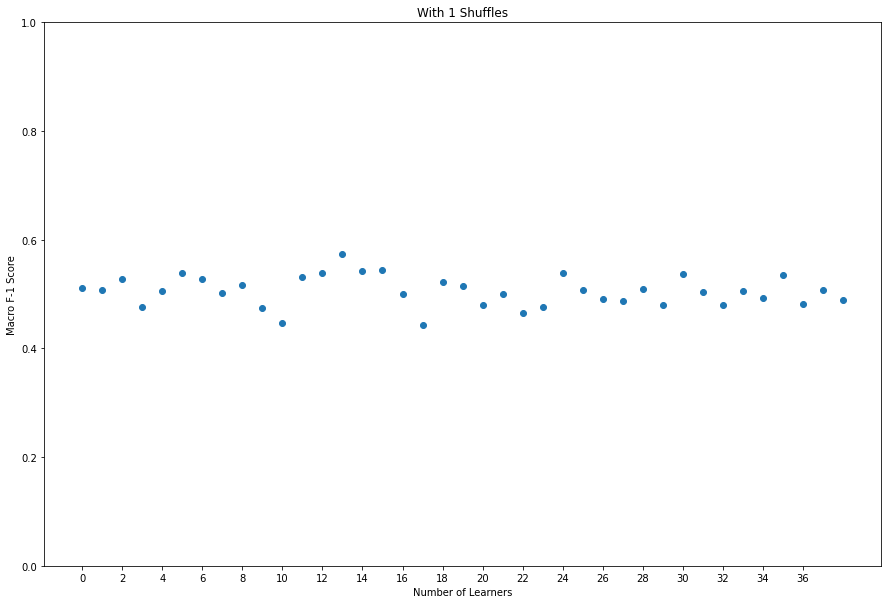

In [134]:

x = range(0,len(firs_exp))
y = [element/num_shuffles for element in f1_over_10.values()]

plt.figure(figsize=(15,10))
plt.scatter(x,y)
plt.xticks([i for i in range(0,38,2)])
plt.xlabel('Number of Learners')
plt.ylabel('Macro F-1 Score')
plt.ylim(0,1)
plt.title('With {} Shuffles'.format(num_shuffles))
plt.show()

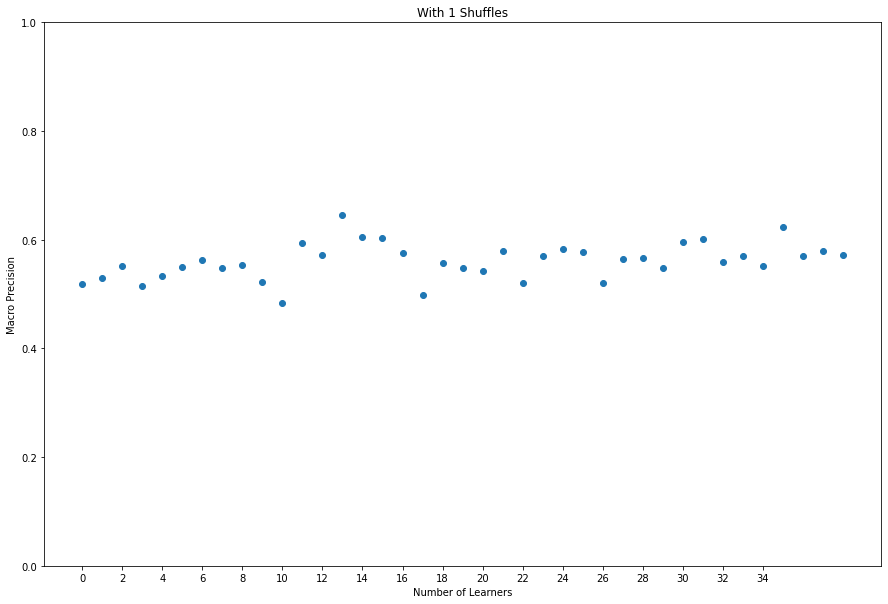

In [135]:
x = range(0,len(firs_exp))
y = [element/num_shuffles for element in precision_over_10.values()]

plt.figure(figsize=(15,10))
plt.scatter(x,y)
plt.xticks([i for i in range(0,36,2)])
plt.xlabel('Number of Learners')
plt.ylabel('Macro Precision')
plt.ylim(0,1)
plt.title('With {} Shuffles'.format(num_shuffles))
plt.show()

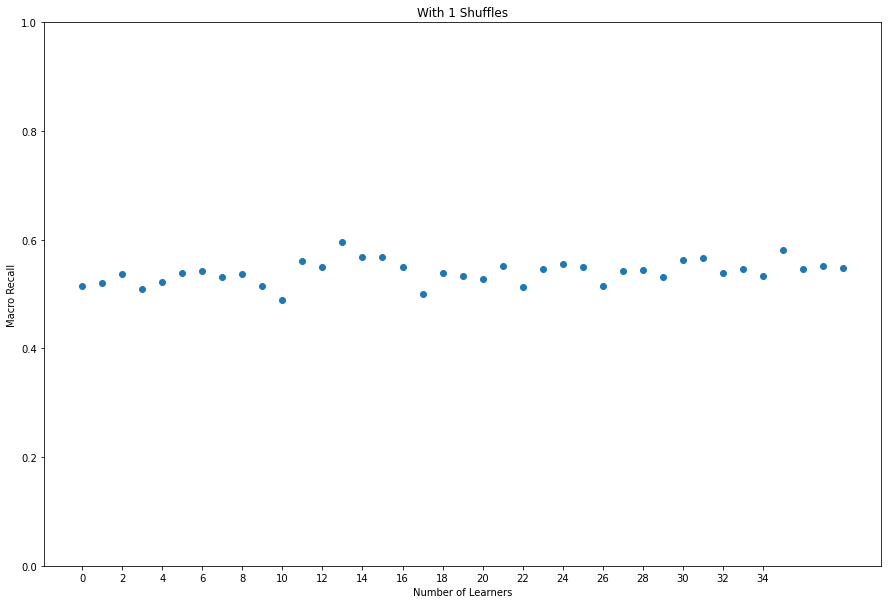

In [136]:

x = range(0,len(firs_exp))
y = [element/num_shuffles for element in recall_over_10.values()]

plt.figure(figsize=(15,10))
plt.scatter(x,y)
plt.xticks([i for i in range(0,36,2)])
plt.xlabel('Number of Learners')
plt.ylabel('Macro Recall')
plt.ylim(0,1)
plt.title('With {} Shuffles'.format(num_shuffles))
plt.show()

In [137]:
all_topics

[(0, 'future business board people think member right need'),
 (1, 'get youre like im way back information going'),
 (2, 'school student career work organization education service get'),
 (3, 'county school santa cruz community program district college'),
 (4, 'know like student people career even lot could'),
 (5, 'like know dont think thats really thing one'),
 (6, 'really know think people make u dont board'),
 (0, 'school student really district know u work theyre'),
 (1, 'community future business people student year lot college'),
 (2, 'know like get program going thing im youre'),
 (3, 'like know dont think student there could career'),
 (4, 'board really dont good think member people director'),
 (5, 'county santa cruz year like partner time every'),
 (6, 'think organization work career want would right funding'),
 (0, 'school county district career santa cruz education high'),
 (1, 'board organization member also new director there think'),
 (2, 'student like people know job f

In [138]:
topic_over_time = pd.DataFrame()
topic_over_time['topic0'] = [i[1] for i in all_topics if i[0] == 0]
topic_over_time['topic1'] = [i[1] for i in all_topics if i[0] == 1]
topic_over_time['topic2'] = [i[1] for i in all_topics if i[0] == 2]
topic_over_time['topic3'] = [i[1] for i in all_topics if i[0] == 3]
topic_over_time['topic4'] = [i[1] for i in all_topics if i[0] == 4]
topic_over_time['topic5'] = [i[1] for i in all_topics if i[0] == 5]
topic_over_time['topic6'] = [i[1] for i in all_topics if i[0] == 6]

In [139]:
topic_over_time

topic0  \
0   future business board people think member righ...   
1   school student really district know u work theyre   
2   school county district career santa cruz educa...   
3   career student education service experience wo...   
4   board organization member new director year s ...   
5   funding school get education w career student ...   
6   school district s community relationship count...   
7   school district county santa cruz relationship...   
8   school community relationship s county like di...   
9    get program education think go there teacher kid   
10  w funding teacher like new organization dont w...   
11       know student like dont w really thats theyre   
12  w funding organization teacher like money woul...   
13  school community s district relationship uniqu...   
14  student s u experience effort career volunteer...   
15  student like people program really community j...   
16       w school student service like know need dont   
17            know like dont think w really would one   
18  school district county relationship santa cruz...   
19      know like think dont really would thing could   
20  s school community district relationship count...   
21          like know dont think w really would thing   
22  education lot program college year different s...   
23  organization u need make strength help thats work   
24       know like think dont going thing really kind   
25    funding w time get money program financial year   
26  student s career experience yfiob people u vol...   
27       know like dont think w really speaker theyre   
28       w know dont like think really school student   
29  school w think strategic future strength could...   
30       know like dont think really would thing work   
31  s board member management people experience or...   
32  student s u career experience yfiob service vo...   
33  student s career u strength yfiob experience s...   
34  s experience volunteer strength different mana...   
35              know think like w dont need new would   
36  s organization community yfiob good people str...   
37  student s career experience u opportunity stre...   
38      school organization u w s plan strategic dont   

                                               topic1  \
0        get youre like im way back information going   
1   community future business people student year ...   
2   board organization member also new director th...   
3           know like think dont could one would yeah   
4           career student theyre get way need im kid   
5   s board management personal member people expe...   
6   board member organization s management directo...   
7    know like dont w really think organization thing   
8              know like dont really one w kind think   
9          like know really dont think one thing kind   
10  s people organization board member good lot yfiob   
11       like really know think people dont new board   
12  board s member people organization experience ...   
13  s board member organization management experie...   
14  s board good organization people member reputa...   
15  s community organization good people yfiob uni...   
16        s community santa cruz u county unique like   
17  school s district community relationship count...   
18         know like dont w think board really theyre   
19  student s career u experience people strength ...   
20      new member kind think year thing really going   
21  s school community district relationship conne...   
22       know like think dont people going could able   
23         know like dont think really w thing people   
24        w know dont like teacher speaker even thats   
25  student s career u experience program people o...   
26        like know dont really think thing get going   
27  organization strength think like would u need get   
28  w funding organization need strategic resource...   
29      funding organization w need resource u s work   

In [140]:

html = topic_over_time.to_html()
  
# write html to file
text_file = open("topics_over_time.html", "w")
text_file.write(html)
text_file.close()